In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import numpy as np
import polars as pl
import itertools
from pathlib import Path
from dask import delayed
from runpy import run_path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import umap.umap_ as umap
import streamlit as st
from sklearn.preprocessing import StandardScaler

import local2global as l2g # ADDED

import torch
import torch_geometric as tg
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx
from torch_geometric.transforms import LargestConnectedComponents
from torch_geometric.utils import to_networkx, from_networkx, one_hot
#from torch_geometric.nn import Node2Vec, GCNConv, VGAE
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import ortho_group

In [60]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import local2global as l2g
import local2global.example as ex
from scipy.stats import ortho_group 
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import local2global as l2g
import local2global.example as ex
import local2global_embedding
from scipy.stats import ortho_group 
from tqdm.notebook import tqdm
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix
import random
#import manopt_optimization as moptim
from torch_geometric.data import Data
import torch_geometric as tg
from local2global_embedding.network import tgraph
from local2global_embedding.patches import create_patch_data
from local2global_embedding.clustering import louvain_clustering
from torch_geometric.utils.convert import from_networkx
import numpy as np
import networkx as nx
import torch
import matplotlib.pyplot as plt
import local2global as l2g
import local2global.example as ex
import local2global_embedding


import torch_geometric as tg
import pandas as pd
from torch_geometric.data import Data
import torch_scatter as ts

import glob
import os

from scipy.linalg import sqrtm
from scipy.sparse import diags


import scipy.sparse as ss
import scipy.sparse.linalg as sl

from local2global import Patch

import matplotlib.cm as cm
from tqdm.notebook import tqdm
import glob

import autograd.numpy as anp
import pymanopt
import pymanopt.manifolds
import pymanopt.optimizers
import random
import local2global as l2g
import local2global.example as ex
import numpy as np
from pymanopt.manifolds import Stiefel, Euclidean,SpecialOrthogonalGroup,  Product
from pymanopt.optimizers import SteepestDescent
import torch
import torch.nn as nn
import torch.optim as optim
from itertools import chain
import itertools
from tqdm.notebook import tqdm

In [61]:
import l2gl
from l2gl.embedding import VGAE, GAE, VGAE_loss, GAE_loss
from l2gl.utils import DataLoader
from l2gl.patch import Patch, AlignmentProblem

In [64]:
import matplotlib
matplotlib.rcParams['figure.max_open_warning'] = 0
import matplotlib.pyplot as plt

#import embedding as emb
import torch_geometric as tg
import local2global as l2g
import torch
import networkx as nx

#ADDED
#import patches as pt
#import network as ntw 
import autograd.numpy as anp
import pymanopt
import pymanopt.manifolds
import pymanopt.optimizers
import random
import local2global as l2g
import local2global.example as ex
import numpy as np

def double_intersections_nodes(patches):
    double_intersections=dict()
    for i in range(len(patches)):
        for j in range(i+1, len(patches)):
            double_intersections[(i,j)]=list(set(patches[i].nodes.tolist()).intersection(set(patches[j].nodes.tolist())))
    return double_intersections
    
import itertools


#import patches as pt
#import network as ntw 
import numpy as np
import geotorch
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import local2global as l2g


import local2global.example as ex
import local2global_embedding
from scipy.stats import ortho_group 
from tqdm.notebook import tqdm
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix
import random
#import manopt_optimization as moptim
from torch_geometric.data import Data
import torch_geometric as tg
from local2global_embedding.network import tgraph
from local2global_embedding.patches import create_patch_data
from local2global_embedding.clustering import louvain_clustering
from tqdm.notebook import tqdm
import scipy.sparse as ss
import scipy.sparse.linalg as sl

import raphtory as rp
from raphtory import Graph as rgraph



import local2global as l2g

import local2global_embedding
from torch_geometric.utils.convert import from_networkx


#from Local2Global_embedding.local2global_embedding import  clustering
import community
#from Local2Global_embedding.local2global_embedding.network import graph
from local2global_embedding.network import TGraph

from torch_geometric.utils import to_networkx


from local2global import Patch
#import Local2Global_embedding.local2global_embedding.embedding.svd as svd
#import Local2Global_embedding.local2global_embedding.embedding.gae as gae
#import Local2Global_embedding.local2global_embedding.patches as patches


import torch_geometric as tg
import torch_scatter as ts
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import numpy as np 
import pandas as pd 
import torch 
import torch.nn.functional as F
import torch.optim as optim
#import optuna
#from optuna.trial import TrialState

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
#from google.colab import drive, files
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.transforms import LargestConnectedComponents

def connected_components(data: tg.data.Data):
    """Find the (weakly)-connected components of graph data. Components are sorted by size, such that id=0 corresponds
     to the largest connected component"""
    edge_index = data.edge_index
    is_undir = tg.utils.is_undirected(edge_index)
    last_components = torch.full((data.num_nodes,), data.num_nodes, dtype=torch.long)
    components = torch.arange(data.num_nodes, dtype=torch.long)
    while not torch.equal(last_components, components):
        last_components[:] = components
        components = ts.scatter(last_components[edge_index[0]], edge_index[1], out=components, reduce='min')
        if not is_undir:
            components = ts.scatter(last_components[edge_index[1]], edge_index[0], out=components, reduce='min')
    component_id, inverse, component_size = torch.unique(components, return_counts=True, return_inverse=True)
    new_id = torch.argsort(component_size, descending=True)
    return new_id[inverse]


def largest_connected_component(data: tg.data.Data):
    """find largest connected component of data"""
    components = connected_components(data)
    nodes = torch.nonzero(components == 0).flatten()
    return induced_subgraph(data, nodes)


def induced_subgraph(data: tg.data.Data, nodes, extend_hops=0):
    nodes = torch.as_tensor(nodes, dtype=torch.long)
    if extend_hops > 0:
        nodes, edge_index, node_map, edge_mask = tg.utils.k_hop_subgraph(nodes, num_hops=extend_hops,
                                                                         edge_index=data.edge_index,
                                                                         relabel_nodes=True)
        edge_attr = data.edge_attr[edge_mask, :] if data.edge_attr is not None else None
    else:
        edge_index, edge_attr = tg.utils.subgraph(nodes, data.edge_index, data.edge_attr, relabel_nodes=True)

    subgraph = tg.data.Data(edge_index=edge_index, edge_attr=edge_attr)
    for key, value in data.__dict__.items():
        if not key.startswith('edge'):
            if hasattr(value, 'shape') and value.shape[0] == data.num_nodes:
                setattr(subgraph, key, value[nodes])
            else:
                setattr(subgraph, key, value)
    subgraph.nodes = nodes
    subgraph.num_nodes = len(nodes)
    return subgraph


def conductance(graph: TGraph, source, target=None):
    if target is None:
        target_mask = torch.ones(graph.num_nodes, dtype=torch.bool, device=graph.device)
        target_mask[source] = False
    else:
        target_mask = torch.zeros(graph.num_nodes, dtype=torch.bool)
        target_mask[target] = True
    out = torch.cat([graph.adj(node) for node in source])
    cond = torch.sum(target_mask[out]).float()
    s_deg = graph.degree[source].sum()
    t_deg = graph.num_edges-s_deg if target is None else graph.degree[target].sum()
    cond /= torch.minimum(s_deg, t_deg)
    return cond


def speye(n, dtype=torch.float):
    """identity matrix of dimension n as sparse_coo_tensor."""
    return torch.sparse_coo_tensor(torch.tile(torch.arange(n, dtype=torch.long), (2, 1)),
                                   torch.ones(n, dtype=dtype),
                                   (n, n))


class DistanceDecoder(torch.nn.Module):
    def __init__(self):
        super(DistanceDecoder, self).__init__()
        self.dist = torch.nn.PairwiseDistance()

    def forward(self, z, edge_index, sigmoid=True):
        value = -self.dist(z[edge_index[0]], z[edge_index[1]])
        return torch.sigmoid(value) if sigmoid else value

    def forward_all(self, z, sigmoid=True):
        adj = torch.cdist(z, z)
        return torch.sigmoid(adj) if sigmoid else adj


class GAEconv(torch.nn.Module):
    def __init__(self, dim, num_node_features, hidden_dim=32, cached=True, bias=True, add_self_loops=True, normalize=True):
        super().__init__()
        self.conv1 = tg.nn.GCNConv(num_node_features, hidden_dim, cached=cached, bias=bias, add_self_loops=add_self_loops,
                                   normalize=normalize)
        self.conv2 = tg.nn.GCNConv(hidden_dim, dim, cached=cached, bias=bias, add_self_loops=add_self_loops,
                                   normalize=normalize)

    def forward(self, data):
        edge_index = data.edge_index
        x = F.relu(self.conv1(data.x, edge_index))
        return self.conv2(x, edge_index)


class VGAEconv(torch.nn.Module):
    def __init__(self, dim, num_node_features, hidden_dim=32, cached=True, bias=True, add_self_loops=True, normalize=True):
        super().__init__()
        self.conv1 = tg.nn.GCNConv(num_node_features, hidden_dim, cached=cached, bias=bias, add_self_loops=add_self_loops,
                                   normalize=normalize)
        self.mean_conv2 = tg.nn.GCNConv(hidden_dim, dim, cached=cached, bias=bias, add_self_loops=add_self_loops,
                                        normalize=normalize)
        self.var_conv2 = tg.nn.GCNConv(hidden_dim, dim, cached=cached, bias=bias, add_self_loops=add_self_loops,
                                       normalize=normalize)

    def forward(self, data: tg.data.Data):
        x = data.x
        edge_index = data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)

        mu = self.mean_conv2(x, edge_index)
        sigma = self.var_conv2(x, edge_index)
        return mu, sigma


def VGAE_loss(model, data):
    return model.recon_loss(model.encode(data), data.edge_index) + model.kl_loss() / data.num_nodes


def VGAE_model(dim, hidden_dim, num_features, dist=False):
    if dist:
        return tg.nn.VGAE(encoder=VGAEconv(dim, num_node_features=num_features, hidden_dim=hidden_dim),
                          decoder=DistanceDecoder())
    else:
        return tg.nn.VGAE(encoder=VGAEconv(dim, num_node_features=num_features, hidden_dim=hidden_dim))


def lr_grid_search(data, model, loss_fun, validation_loss_fun, lr_grid=(0.1, 0.01, 0.005, 0.001),
                   num_epochs=10, runs=1, verbose=True):
    val_loss = torch.zeros((len(lr_grid), runs))
    val_start = torch.zeros((len(lr_grid), runs))
    for i, lr in enumerate(lr_grid):
        for r in range(runs):
            model.reset_parameters()
            val_start[i, r] = validation_loss_fun(model, data)
            model = train(data, model, loss_fun, num_epochs=num_epochs, lr=lr, verbose=verbose)
            val_loss[i, r] = validation_loss_fun(model, data)
    model.reset_parameters()
    return lr_grid[torch.argmax(torch.mean(val_loss, 1))], val_loss, val_start


def train(data, model, loss_fun, num_epochs=100, verbose=True, lr=0.01, logger=lambda loss: None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    # schedule = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
    for e in range(num_epochs):
        optimizer.zero_grad()
        loss = loss_fun(model, data)
        loss.backward()
        optimizer.step()
        logger(float(loss))
        if verbose:
            print(f'epoch {e}: loss={loss.item()}')
        # schedule.step()
    return model


def VGAE_patch_embeddings(patch_data, dim=2, hidden_dim=32, num_epochs=100, decoder=None, device='cpu', lr=0.01):
    patch_list = []
    models = []
    for patch in patch_data:
        #for i in range(len(patch)):#added this for loop and replace the commented part with this
            #if patch[i].x is None:
                #patch[i].x=speye(patch[i].num_nodes)
        
        
        if patch.x is None:
            patch.x = speye(patch.num_nodes)
        print(f"training patch with {patch.edge_index.shape[1]} edges")   #added [i] to every patch
        model = tg.nn.VGAE(encoder=VGAEconv(dim, patch.x.shape[1], hidden_dim=hidden_dim), decoder=decoder).to(device)
        patch.to(device)

        def loss_fun(model, data):
            return model.recon_loss(model.encode(data), data.edge_index) + model.kl_loss() / data.num_nodes

        model = train(patch, model, loss_fun, num_epochs=num_epochs, lr=lr)
        with torch.no_grad():
            model.eval()
            coordinates = model.encode(patch).to('cpu').numpy()
            models.append(model)
            patch_list.append(l2g.Patch(patch.nodes.to('cpu').numpy(), coordinates))
    return patch_list, models


def GAE_patch_embeddings(patch_data, dim=2, hidden_dim=32, num_epochs=100, device='cpu', decoder=None, lr=0.01):
    patch_list = []
    models = []
    for patch in patch_data:
        if patch.x is None:
            patch.x = speye(patch.num_nodes)
        print(f"training patch with {patch.edge_index.shape[1]} edges")
        model = tg.nn.GAE(encoder=GAEconv(dim, patch.x.shape[1], hidden_dim=hidden_dim), decoder=decoder).to(device)
        patch.to(device)

        def loss_fun(model, data):
            return model.recon_loss(model.encode(data), data.edge_index)
        model.train()
        model = train(patch, model, loss_fun, num_epochs=num_epochs, lr=lr)
        model.eval()
        coordinates = model.encode(patch).to('cpu').data.numpy()
        patch.to('cpu')
        models.append(model)
        patch_list.append(l2g.Patch(patch.nodes.numpy(), coordinates))
    return patch_list, models

In [65]:
#import manopt_optimization as mopt

In [66]:
PATH = "../data/nas/"

# <font color="grey"> Autonomous Systems</font>

The purpose of this notebook is to walk through the graph embedding and alignment process in a self-contained way. The full existing Local2Global package is available [here](https://github.com/LJeub/Local2Global_embedding) and the expectation is to pick parts from it as a starting point. It is also available in on this repository in the Local2Global_embedding folder for reference.

### <font color="grey">  Table of Contents</font>

1. #### <a href='#chapter1'>Data</a>
2. #### <a href='#chapter2'>Embedding</a>
3. #### <a href='#chapter3'>Visualisation</a>

###  <a id='chapter1'> <font color="grey">1. Data </font></a>

The data can be accessed via the dataloader. It is saved in the datasets/data/nas directory in two parquet files. There are many alternative ways of doing this. One option to explore is to have the datasets available as in [torch_geometric datasets](https://pytorch-geometric.readthedocs.io/en/2.6.0/modules/datasets.html).

In [67]:
dl = DataLoader(dset='nas')

The data is stored in one dataframe for the nodes (including all the features) and one for the edges (including edge weights).

In [68]:
# Get the nodes
node_df = dl.get_nodes()
node_df.head()

timestamp,nodes,nodetype,country,asname,nodename,cc
datetime[μs],i64,str,str,str,str,i64
2024-09-14 00:00:00,0,"""asn""","""US""","""WINDSTREAM""","""AS7029""",235
2024-09-14 00:00:00,1,"""asn""","""US""","""RUELALA-INC""","""AS32984""",235
2024-09-14 00:00:00,2,"""asn""","""ID""","""FIBERSTAR-AS-I""","""AS136106""",104
2024-09-14 00:00:00,3,"""asn""","""ID""","""HSPNET-AS-I""","""AS58495""",104
2024-09-14 00:00:00,4,"""asn""","""US""","""BTN-ASN""","""AS3491""",235


In [69]:
edge_df = dl.get_edges()
edge_df.head()

timestamp,source,dest,weight
datetime[μs],i64,i64,i64
2024-09-14 00:00:00,0,1,1
2024-09-14 00:00:00,0,465,1
2024-09-14 00:00:00,0,596,1
2024-09-14 00:00:00,0,1234,1
2024-09-14 00:00:00,0,1272,1


Ultimately, working with the people at Pometry, we want to use the [Raphtory](https://www.raphtory.com/) graph format.

In [70]:
# Raphtory format
g = dl.get_graph()

The Raphtory formal is still work in progress but one can contribute to their code (based in Rust), contribute to the discussion on their Slack (linked on their page) or directly get in touch with [Lucas Jeub](https://github.com/LJeub) and/or Ben Steer.

In [71]:
print("Stats on the graph structure:")

number_of_nodes = g.count_nodes()
number_of_edges = g.count_edges()
total_interactions = g.count_temporal_edges()

print("Number of nodes (AS nodes):", number_of_nodes)
print("Number of unique edges (src,dst):", number_of_edges)
print("Total interactions (edge updates):", total_interactions)

print("Stats on the graphs time range:")

earliest_datetime = g.earliest_date_time
latest_datetime = g.latest_date_time

print("Earliest datetime:", earliest_datetime)
print("Latest datetime:", latest_datetime)

Stats on the graph structure:
Number of nodes (AS nodes): 85428
Number of unique edges (src,dst): 914346
Total interactions (edge updates): 16717484
Stats on the graphs time range:
Earliest datetime: 2024-09-14 00:00:00+00:00
Latest datetime: 2024-10-13 00:00:00+00:00


In [72]:
print("The node features are: ", g.nodes.properties.keys())

The node features are:  ['asname', 'cc', 'country', 'nodename', 'nodetype']


The graphs we are dealing are **temporal**, meaning that nodes and edges have timestamps. One can interpret this as having one graph for each point in time, with a possible overlap of nodes and edges.

In [73]:
dates = dl.get_dates()

For this particular dataset, the graph for each day represents a patch. In order to apply graph neural networks to each patch, we need to process these into the Data format used by pytorch-geometric, described [here](https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html). In particular, for each patch we need to enumerate the nodes and use these indices to designate the nodes. We need a dictionary that maps the nodes in each patch to their names and we need to encode the node and edge features.

In [74]:
# Encode nodes present at each date
nodes = {}
node_dict = {}
for d in dates:
    nodes[d] = dl.get_node_list(ts=d)
    node_dict[d] = dict(zip(nodes[d],range(len(nodes[d]))))
all_nodes = dl.get_node_list()

In [75]:
numbering_nodes= {x : i for i, x in enumerate(all_nodes)}
list_nodes=list(nodes.values())

list_nodes_renumbered=[]
for l in list_nodes:
    list_nodes_renumbered.append( [numbering_nodes[i] for i in l])

In [76]:
# Encode country codes
cc = pl.read_csv('data/nas/country_codes.csv')
countrycode_dict = dict(zip(cc["alpha-2"].to_list(), range(cc.shape[0])))
#cc_one_hot = one_hot(torch.tensor(list(countrycode_dict.values()), dtype=torch.int64))

In [77]:
# Assign country code index to each node. The way this is done is a bit convoluted, as some nodes are assigned to both a country and to 'ZZ'
# in the database, so we need to fix that. This should be done in pre-processing
df = dl.get_nodes().with_columns(
    pl.col("country").replace(old=pl.Series(countrycode_dict.keys()), new=pl.Series(countrycode_dict.values())).cast(pl.Int64).alias('cc')
).select(["nodes", "cc"]).group_by("nodes").agg(pl.col("cc").min().cast(pl.Int64).alias("cc")).sort(["cc","nodes"])
node_cc_dict = dict(zip(df["nodes"].to_list(), df["cc"].to_list()))

In [78]:
# For every day, create a list of node features
features = {}
for d in dates:
    features[d] = one_hot(torch.tensor(dl.get_nodes(ts=d).select(
        pl.col("country").replace(old=pl.Series(countrycode_dict.keys()), new=pl.Series(countrycode_dict.values())).cast(pl.Int64)
    ).to_numpy().flatten()))

In [79]:
features[dates[3]].shape

torch.Size([84575, 250])

In [80]:
# Create pytorch-geometric Data object
tg_graphs = {}
for d in tqdm(dates):
    edges = dl.edges.filter(pl.col('timestamp')==d).select(
        pl.col('source').replace(old=pl.Series(node_dict[d].keys()), new=pl.Series(node_dict[d].values())).cast(pl.Int64),
        pl.col('dest').replace(old=pl.Series(node_dict[d].keys()), new=pl.Series(node_dict[d].values())).cast(pl.Int64)
    ).to_numpy()
    edge_index = torch.tensor([tuple(x) for x in edges], dtype=torch.long).t().contiguous()
    tgraph = Data(edge_index=edge_index)
    # Add features - problem is that for the embedding we only want those present at a given time
    tgraph.x = features[d]
    tg_graphs[d] = tgraph

  0%|          | 0/30 [00:00<?, ?it/s]

In [81]:
for i, d in enumerate(dates):
    tg_graphs[d].nodes=torch.tensor(list_nodes_renumbered[i])

In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from local2global_embedding.patches import create_patch_data
from local2global_embedding.clustering import louvain_clustering

In [89]:
test_data=tg_graphs[dates[0]]
cc=test_data

In [100]:
TG=TGraph(edge_index=cc.edge_index, edge_attr=cc.edge_attr,  num_nodes=cc.num_nodes, ensure_sorted=True, undir=False)
pt, pgraph= create_patch_data(TG, partition_tensor= louvain_clustering(TG),
                                           min_overlap=2000, target_overlap=4000, verbose=True)
patch_data = [induced_subgraph(cc, p) for p in pt]

number of patches: 11
average patch degree: 3.6363636363636362


enlarging patch overlaps:   0%|          | 0/11 [00:00<?, ?it/s]

In [105]:
pgraph.connected_component_ids()

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [106]:
neg_edges = tg.utils.negative_sampling(test_data.edge_index, num_nodes=test_data.num_nodes)

In [107]:
def double_intersections_nodes(patches):
    double_intersections = dict()
    for i in range(len(patches)):
        for j in range(i+1, len(patches)):
            double_intersections[(i,j)]=list(set(patches[i].nodes.tolist()).intersection(set(patches[j].nodes.tolist())))
    return double_intersections

def preprocess_graphs(list_of_patches, nodes_dict):
    emb_list = []
    for i in range(len(list_of_patches)-1):
        emb_list.append([torch.tensor(list_of_patches[i].get_coordinates(list(nodes_dict[i,i+1]))),
                         torch.tensor(list_of_patches[i+1].get_coordinates(list(nodes_dict[i,i+1])))])
    emb_list = list(itertools.chain.from_iterable(emb_list))
    return emb_list    

def get_embedding(patches, result):
    n=len(patches)
    rot=[result.transformation[i].weight.to('cpu').detach().numpy() for i in range(n)]
    shift=[result.transformation[i].bias.to('cpu').detach().numpy() for i in range(n)]

    emb_problem = l2g.AlignmentProblem(patches)
    embedding = np.empty((emb_problem.n_nodes, emb_problem.dim))
    for node, patch_list in enumerate(emb_problem.patch_index):
        embedding[node] = np.mean([emb_problem.patches[p].get_coordinate(node)@rot[i] + shift[i] for i, p in enumerate(patch_list)], axis=0)

    #prob=l2g.AlignmentProblem(patches)
    #old_embedding=prob.get_aligned_embedding()
    #embedding=embedding[nodes]
    #old_embedding=old_embedding[nodes]
    #error= l2g.utils.procrustes_error(embedding,old_embedding)

    return embedding


import torch
import torch.nn as nn
import geotorch


    
class Model(nn.Module):
    def __init__(self, dim, n_patches, device):
        super().__init__()
        self.device = device
        self.transformation = nn.ParameterList([nn.Linear(dim, dim).to(device) for _ in range(n_patches)])
        [geotorch.orthogonal(self.transformation[i], 'weight') for i in range(n_patches)]
    
    def forward(self, patch_emb):
        m = len(patch_emb)
        transformations = [self.transformation[0]] + [item for i in range(1, len(self.transformation)-1) for item in (self.transformation[i], self.transformation[i])] + [self.transformation[-1]]
        transformed_emb = [transformations[i](patch_emb[i]) for i in range(m)]
        return transformed_emb

def loss_function(transformed_emb):
    m = len(transformed_emb)
    diff = [transformed_emb[i] - transformed_emb[i+1] for i in range(0, m-1, 2)]
    loss = sum([torch.norm(d) ** 2 for d in diff])
    return loss

def train_model(patch_emb, dim, n_patches, num_epochs=100, learning_rate=0.05):
    #device = get_device()
    patch_emb = [p.to(device) for p in patch_emb]
    
    model = Model(dim, n_patches, device).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_hist = []
    
    for epoch in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        transformed_patch_emb = model(patch_emb)
        loss = loss_function(transformed_patch_emb)
        loss.backward(retain_graph=True)
        optimizer.step()
        loss_hist.append(loss.item())
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    
    return model, loss_hist


In [108]:
patches, models =VGAE_patch_embeddings(patch_data, dim=2, num_epochs=10, device=device)

training patch with 267352 edges
epoch 0: loss=1.7359555959701538
epoch 1: loss=1.6621803045272827
epoch 2: loss=1.606276273727417
epoch 3: loss=1.5505645275115967
epoch 4: loss=1.477251648902893
epoch 5: loss=1.3987598419189453
epoch 6: loss=1.3191851377487183
epoch 7: loss=1.245455026626587
epoch 8: loss=1.187490463256836
epoch 9: loss=1.148565649986267
training patch with 227552 edges
epoch 0: loss=1.7511072158813477
epoch 1: loss=1.673311471939087
epoch 2: loss=1.6395832300186157
epoch 3: loss=1.5861210823059082
epoch 4: loss=1.5454611778259277
epoch 5: loss=1.501560926437378
epoch 6: loss=1.4711217880249023
epoch 7: loss=1.4074918031692505
epoch 8: loss=1.3496296405792236
epoch 9: loss=1.2981318235397339
training patch with 82345 edges
epoch 0: loss=1.7866861820220947
epoch 1: loss=1.6616477966308594
epoch 2: loss=1.6082724332809448
epoch 3: loss=1.553657054901123
epoch 4: loss=1.5102276802062988
epoch 5: loss=1.4861811399459839
epoch 6: loss=1.4531774520874023
epoch 7: loss=1.434

In [110]:
nodes = double_intersections_nodes(patches)
n_patches=len(patch_data)

In [111]:
dimensions=[16, 32, 64, 128, 256, 512]
AUC=[]
AP=[]
Loss=[]
PATCHES=[]
new_emb=[]
for dim in dimensions:
    patches_ip, models_ip =VGAE_patch_embeddings(patch_data, dim=dim, num_epochs=200, device=device)
    PATCHES.append(patches_ip)
    emb_patches = preprocess_graphs(patches_ip, nodes)
    res, loss_hist= train_model(emb_patches, dim, n_patches , num_epochs=200, learning_rate=0.05)
    emb=get_embedding(patches_ip, res)
    new_emb.append(emb)
    full_model_ip = tg.nn.VGAE(encoder=VGAEconv(dim, test_data.num_node_features))
    auc, ap = full_model_ip.test(torch.tensor(emb), test_data.edge_index, neg_edges)
    AUC.append(auc)
    AP.append(ap)
    Loss.append(loss_hist)

training patch with 267352 edges
epoch 0: loss=3.3803491592407227
epoch 1: loss=3.2017617225646973
epoch 2: loss=2.9764645099639893
epoch 3: loss=2.72951340675354
epoch 4: loss=2.443437337875366
epoch 5: loss=2.160477876663208
epoch 6: loss=1.9462767839431763
epoch 7: loss=1.8809869289398193
epoch 8: loss=1.8086410760879517
epoch 9: loss=1.745955228805542
epoch 10: loss=1.6426869630813599
epoch 11: loss=1.5413724184036255
epoch 12: loss=1.4410698413848877
epoch 13: loss=1.3566539287567139
epoch 14: loss=1.2828290462493896
epoch 15: loss=1.2329386472702026
epoch 16: loss=1.2091323137283325
epoch 17: loss=1.1904027462005615
epoch 18: loss=1.1756504774093628
epoch 19: loss=1.1506531238555908
epoch 20: loss=1.1257439851760864
epoch 21: loss=1.0951958894729614
epoch 22: loss=1.062516450881958
epoch 23: loss=1.038589596748352
epoch 24: loss=1.0206166505813599
epoch 25: loss=1.008203387260437
epoch 26: loss=0.9912413954734802
epoch 27: loss=0.9794285297393799
epoch 28: loss=0.9683055877685547

epoch 38: loss=0.9358625411987305
epoch 39: loss=0.9310645461082458
epoch 40: loss=0.9253315329551697
epoch 41: loss=0.922662079334259
epoch 42: loss=0.9184541702270508
epoch 43: loss=0.9162020087242126
epoch 44: loss=0.9114007949829102
epoch 45: loss=0.9126311540603638
epoch 46: loss=0.909781813621521
epoch 47: loss=0.9086111187934875
epoch 48: loss=0.9077298641204834
epoch 49: loss=0.9079844951629639
epoch 50: loss=0.9087450504302979
epoch 51: loss=0.9073195457458496
epoch 52: loss=0.9038164019584656
epoch 53: loss=0.903339147567749
epoch 54: loss=0.9032831788063049
epoch 55: loss=0.9022058844566345
epoch 56: loss=0.9009082913398743
epoch 57: loss=0.900631308555603
epoch 58: loss=0.8982632160186768
epoch 59: loss=0.8975989818572998
epoch 60: loss=0.8982361555099487
epoch 61: loss=0.896817684173584
epoch 62: loss=0.8984781503677368
epoch 63: loss=0.8966176509857178
epoch 64: loss=0.8955023884773254
epoch 65: loss=0.8952913880348206
epoch 66: loss=0.8951047658920288
epoch 67: loss=0.89

epoch 77: loss=0.9144214987754822
epoch 78: loss=0.9099203944206238
epoch 79: loss=0.9084603190422058
epoch 80: loss=0.9119549989700317
epoch 81: loss=0.908737063407898
epoch 82: loss=0.9076113700866699
epoch 83: loss=0.9055600166320801
epoch 84: loss=0.9042571783065796
epoch 85: loss=0.9045106172561646
epoch 86: loss=0.9051721096038818
epoch 87: loss=0.9046854972839355
epoch 88: loss=0.9021345376968384
epoch 89: loss=0.9026337265968323
epoch 90: loss=0.9019650816917419
epoch 91: loss=0.9007278084754944
epoch 92: loss=0.8962216973304749
epoch 93: loss=0.8966234922409058
epoch 94: loss=0.8957875967025757
epoch 95: loss=0.8955021500587463
epoch 96: loss=0.8925356864929199
epoch 97: loss=0.8953922986984253
epoch 98: loss=0.892702043056488
epoch 99: loss=0.8929826617240906
epoch 100: loss=0.8915943503379822
epoch 101: loss=0.8906749486923218
epoch 102: loss=0.8906375169754028
epoch 103: loss=0.8896006941795349
epoch 104: loss=0.8900307416915894
epoch 105: loss=0.8891599774360657
epoch 106:

epoch 128: loss=1.403228759765625
epoch 129: loss=1.403459906578064
epoch 130: loss=1.3698235750198364
epoch 131: loss=1.424861192703247
epoch 132: loss=1.4801326990127563
epoch 133: loss=1.4249908924102783
epoch 134: loss=1.372894525527954
epoch 135: loss=1.4384506940841675
epoch 136: loss=1.3725333213806152
epoch 137: loss=1.4035862684249878
epoch 138: loss=1.448933720588684
epoch 139: loss=1.4370428323745728
epoch 140: loss=1.3864883184432983
epoch 141: loss=1.4663569927215576
epoch 142: loss=1.4175732135772705
epoch 143: loss=1.3927245140075684
epoch 144: loss=1.4315046072006226
epoch 145: loss=1.4554017782211304
epoch 146: loss=1.385933756828308
epoch 147: loss=1.3707680702209473
epoch 148: loss=1.3775897026062012
epoch 149: loss=1.36544930934906
epoch 150: loss=1.3964121341705322
epoch 151: loss=1.3889758586883545
epoch 152: loss=1.4027787446975708
epoch 153: loss=1.43816339969635
epoch 154: loss=1.5469025373458862
epoch 155: loss=1.4495539665222168
epoch 156: loss=1.397501111030

epoch 166: loss=0.8222336769104004
epoch 167: loss=0.8215314149856567
epoch 168: loss=0.8206286430358887
epoch 169: loss=0.8226398229598999
epoch 170: loss=0.8211331367492676
epoch 171: loss=0.8208786249160767
epoch 172: loss=0.8193814754486084
epoch 173: loss=0.8212470412254333
epoch 174: loss=0.8216792941093445
epoch 175: loss=0.8204630017280579
epoch 176: loss=0.8208373188972473
epoch 177: loss=0.8213520050048828
epoch 178: loss=0.8204180002212524
epoch 179: loss=0.8201457262039185
epoch 180: loss=0.8170930743217468
epoch 181: loss=0.8206396698951721
epoch 182: loss=0.8192713856697083
epoch 183: loss=0.8188873529434204
epoch 184: loss=0.8177047371864319
epoch 185: loss=0.8197407722473145
epoch 186: loss=0.8181790709495544
epoch 187: loss=0.8195943832397461
epoch 188: loss=0.8164938688278198
epoch 189: loss=0.8184218406677246
epoch 190: loss=0.8169859647750854
epoch 191: loss=0.816106915473938
epoch 192: loss=0.816874086856842
epoch 193: loss=0.8170486092567444
epoch 194: loss=0.8174

epoch 4: loss=2.6650497913360596
epoch 5: loss=2.4037041664123535
epoch 6: loss=2.163698196411133
epoch 7: loss=1.9856301546096802
epoch 8: loss=1.8421283960342407
epoch 9: loss=1.7934921979904175
epoch 10: loss=1.745097041130066
epoch 11: loss=1.6746360063552856
epoch 12: loss=1.5960750579833984
epoch 13: loss=1.5057471990585327
epoch 14: loss=1.415786623954773
epoch 15: loss=1.3455109596252441
epoch 16: loss=1.2869081497192383
epoch 17: loss=1.2515312433242798
epoch 18: loss=1.2247921228408813
epoch 19: loss=1.2097601890563965
epoch 20: loss=1.1946369409561157
epoch 21: loss=1.178330898284912
epoch 22: loss=1.147071123123169
epoch 23: loss=1.1190619468688965
epoch 24: loss=1.0892175436019897
epoch 25: loss=1.0685361623764038
epoch 26: loss=1.0548721551895142
epoch 27: loss=1.040958285331726
epoch 28: loss=1.0281586647033691
epoch 29: loss=1.0146769285202026
epoch 30: loss=0.9967154264450073
epoch 31: loss=0.9825847744941711
epoch 32: loss=0.9667924046516418
epoch 33: loss=0.958108365

epoch 44: loss=0.9234265089035034
epoch 45: loss=0.9212979078292847
epoch 46: loss=0.9196991920471191
epoch 47: loss=0.9224351048469543
epoch 48: loss=0.9179016351699829
epoch 49: loss=0.917789876461029
epoch 50: loss=0.9126793742179871
epoch 51: loss=0.912865161895752
epoch 52: loss=0.9125294089317322
epoch 53: loss=0.9091896414756775
epoch 54: loss=0.9097324013710022
epoch 55: loss=0.9084344506263733
epoch 56: loss=0.904858410358429
epoch 57: loss=0.9064518213272095
epoch 58: loss=0.9068124294281006
epoch 59: loss=0.9033241271972656
epoch 60: loss=0.9027683138847351
epoch 61: loss=0.9034437537193298
epoch 62: loss=0.902442991733551
epoch 63: loss=0.9026429653167725
epoch 64: loss=0.9006290435791016
epoch 65: loss=0.9006749391555786
epoch 66: loss=0.8998895287513733
epoch 67: loss=0.8985588550567627
epoch 68: loss=0.8980064988136292
epoch 69: loss=0.8980503678321838
epoch 70: loss=0.8966546654701233
epoch 71: loss=0.8965921401977539
epoch 72: loss=0.89798903465271
epoch 73: loss=0.896

epoch 86: loss=0.882440984249115
epoch 87: loss=0.8831139206886292
epoch 88: loss=0.8829156756401062
epoch 89: loss=0.8825123906135559
epoch 90: loss=0.8807551860809326
epoch 91: loss=0.8806307315826416
epoch 92: loss=0.8822363615036011
epoch 93: loss=0.8801677823066711
epoch 94: loss=0.8828320503234863
epoch 95: loss=0.8807642459869385
epoch 96: loss=0.8808561563491821
epoch 97: loss=0.880989670753479
epoch 98: loss=0.8792816400527954
epoch 99: loss=0.8784233331680298
epoch 100: loss=0.8789570927619934
epoch 101: loss=0.8795667886734009
epoch 102: loss=0.8771572709083557
epoch 103: loss=0.878426730632782
epoch 104: loss=0.8779009580612183
epoch 105: loss=0.8806297183036804
epoch 106: loss=0.8801433444023132
epoch 107: loss=0.8763933777809143
epoch 108: loss=0.8771058917045593
epoch 109: loss=0.8784858584403992
epoch 110: loss=0.877678394317627
epoch 111: loss=0.8773868083953857
epoch 112: loss=0.8773137927055359
epoch 113: loss=0.8764650821685791
epoch 114: loss=0.8782241940498352
epo

epoch 124: loss=0.8737784028053284
epoch 125: loss=0.8740003705024719
epoch 126: loss=0.8734650015830994
epoch 127: loss=0.8729780316352844
epoch 128: loss=0.8720861673355103
epoch 129: loss=0.8721834421157837
epoch 130: loss=0.8727312088012695
epoch 131: loss=0.8721343874931335
epoch 132: loss=0.8707138895988464
epoch 133: loss=0.8730029463768005
epoch 134: loss=0.8712852597236633
epoch 135: loss=0.8713357448577881
epoch 136: loss=0.8725274205207825
epoch 137: loss=0.8717661499977112
epoch 138: loss=0.8714858889579773
epoch 139: loss=0.8668711185455322
epoch 140: loss=0.8696119785308838
epoch 141: loss=0.8724193572998047
epoch 142: loss=0.8717387318611145
epoch 143: loss=0.8708440065383911
epoch 144: loss=0.868493914604187
epoch 145: loss=0.8693253397941589
epoch 146: loss=0.8671646118164062
epoch 147: loss=0.8669858574867249
epoch 148: loss=0.8706962466239929
epoch 149: loss=0.8706303834915161
epoch 150: loss=0.8686259984970093
epoch 151: loss=0.8667829632759094
epoch 152: loss=0.868

epoch 163: loss=0.8769655227661133
epoch 164: loss=0.8754913210868835
epoch 165: loss=0.8757636547088623
epoch 166: loss=0.8764020204544067
epoch 167: loss=0.8765267729759216
epoch 168: loss=0.8781284093856812
epoch 169: loss=0.8769463300704956
epoch 170: loss=0.8750534057617188
epoch 171: loss=0.875176727771759
epoch 172: loss=0.8763963580131531
epoch 173: loss=0.8767045736312866
epoch 174: loss=0.8760936260223389
epoch 175: loss=0.8772964477539062
epoch 176: loss=0.8774537444114685
epoch 177: loss=0.8754714131355286
epoch 178: loss=0.8776246905326843
epoch 179: loss=0.876829206943512
epoch 180: loss=0.8766036033630371
epoch 181: loss=0.8764053583145142
epoch 182: loss=0.874480128288269
epoch 183: loss=0.8760537505149841
epoch 184: loss=0.8756538033485413
epoch 185: loss=0.8751910924911499
epoch 186: loss=0.876029372215271
epoch 187: loss=0.8748378157615662
epoch 188: loss=0.875542938709259
epoch 189: loss=0.8751617074012756
epoch 190: loss=0.8747153282165527
epoch 191: loss=0.8749598

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0, Loss: 97207.2421875
Epoch 10, Loss: 21587.251953125
Epoch 20, Loss: 15191.185546875
Epoch 30, Loss: 13179.818359375
Epoch 40, Loss: 12474.60546875
Epoch 50, Loss: 12143.6083984375
Epoch 60, Loss: 11986.3349609375
Epoch 70, Loss: 11912.2734375
Epoch 80, Loss: 11871.685546875
Epoch 90, Loss: 11846.33203125
Epoch 100, Loss: 11828.7919921875
Epoch 110, Loss: 11815.45703125
Epoch 120, Loss: 11804.75390625
Epoch 130, Loss: 11795.8603515625
Epoch 140, Loss: 11788.2734375
Epoch 150, Loss: 11781.7197265625
Epoch 160, Loss: 11776.0146484375
Epoch 170, Loss: 11771.025390625
Epoch 180, Loss: 11766.646484375
Epoch 190, Loss: 11762.7958984375
training patch with 267352 edges
epoch 0: loss=4.612177848815918
epoch 1: loss=4.504603385925293
epoch 2: loss=4.265945911407471
epoch 3: loss=4.096076011657715
epoch 4: loss=3.846025228500366
epoch 5: loss=3.5331151485443115
epoch 6: loss=3.1815521717071533
epoch 7: loss=2.8543035984039307
epoch 8: loss=2.5904104709625244
epoch 9: loss=2.4571506977081

epoch 20: loss=1.5269536972045898
epoch 21: loss=1.4980027675628662
epoch 22: loss=1.4463587999343872
epoch 23: loss=1.4185889959335327
epoch 24: loss=1.3623391389846802
epoch 25: loss=1.3111231327056885
epoch 26: loss=1.2529550790786743
epoch 27: loss=1.200234055519104
epoch 28: loss=1.1594982147216797
epoch 29: loss=1.1282124519348145
epoch 30: loss=1.0995261669158936
epoch 31: loss=1.0749562978744507
epoch 32: loss=1.0507148504257202
epoch 33: loss=1.0292631387710571
epoch 34: loss=1.0065357685089111
epoch 35: loss=0.9918495416641235
epoch 36: loss=0.9802130460739136
epoch 37: loss=0.9774495363235474
epoch 38: loss=0.9698325395584106
epoch 39: loss=0.96272873878479
epoch 40: loss=0.9528959393501282
epoch 41: loss=0.9399658441543579
epoch 42: loss=0.9353577494621277
epoch 43: loss=0.9274529814720154
epoch 44: loss=0.9258549213409424
epoch 45: loss=0.9236277937889099
epoch 46: loss=0.9208487868309021
epoch 47: loss=0.9145657420158386
epoch 48: loss=0.9109350442886353
epoch 49: loss=0.

epoch 59: loss=0.9453089237213135
epoch 60: loss=0.9430482983589172
epoch 61: loss=0.9456353187561035
epoch 62: loss=0.9436289668083191
epoch 63: loss=0.942068874835968
epoch 64: loss=0.9428364634513855
epoch 65: loss=0.9428065419197083
epoch 66: loss=0.9420298337936401
epoch 67: loss=0.9415183067321777
epoch 68: loss=0.9412574172019958
epoch 69: loss=0.939270555973053
epoch 70: loss=0.9391975402832031
epoch 71: loss=0.9398877024650574
epoch 72: loss=0.9372522830963135
epoch 73: loss=0.9344562292098999
epoch 74: loss=0.9359439611434937
epoch 75: loss=0.9348883032798767
epoch 76: loss=0.9341148734092712
epoch 77: loss=0.9359493851661682
epoch 78: loss=0.9340367913246155
epoch 79: loss=0.9328848123550415
epoch 80: loss=0.9317854046821594
epoch 81: loss=0.9338986277580261
epoch 82: loss=0.9330115914344788
epoch 83: loss=0.9318273663520813
epoch 84: loss=0.9300010800361633
epoch 85: loss=0.9319599866867065
epoch 86: loss=0.9290816187858582
epoch 87: loss=0.9283549785614014
epoch 88: loss=0

epoch 110: loss=1.388581395149231
epoch 111: loss=1.4163711071014404
epoch 112: loss=1.3743184804916382
epoch 113: loss=1.3654348850250244
epoch 114: loss=1.4190939664840698
epoch 115: loss=1.4122141599655151
epoch 116: loss=1.504091501235962
epoch 117: loss=1.468527913093567
epoch 118: loss=1.4316033124923706
epoch 119: loss=1.3690011501312256
epoch 120: loss=1.4021025896072388
epoch 121: loss=1.3984463214874268
epoch 122: loss=1.4672356843948364
epoch 123: loss=1.4087464809417725
epoch 124: loss=1.4047163724899292
epoch 125: loss=1.4423093795776367
epoch 126: loss=1.4367929697036743
epoch 127: loss=1.433138370513916
epoch 128: loss=1.4493683576583862
epoch 129: loss=1.4569587707519531
epoch 130: loss=1.416630744934082
epoch 131: loss=1.4688706398010254
epoch 132: loss=1.2895525693893433
epoch 133: loss=1.410771369934082
epoch 134: loss=1.4195939302444458
epoch 135: loss=1.3939189910888672
epoch 136: loss=1.4217933416366577
epoch 137: loss=1.4313433170318604
epoch 138: loss=1.47132456

epoch 148: loss=0.8271594643592834
epoch 149: loss=0.8264183402061462
epoch 150: loss=0.8260393738746643
epoch 151: loss=0.8250260949134827
epoch 152: loss=0.8263924717903137
epoch 153: loss=0.8277398943901062
epoch 154: loss=0.8263505697250366
epoch 155: loss=0.8245023488998413
epoch 156: loss=0.8247127532958984
epoch 157: loss=0.8254498839378357
epoch 158: loss=0.8246276378631592
epoch 159: loss=0.8247042894363403
epoch 160: loss=0.8237774968147278
epoch 161: loss=0.8233165740966797
epoch 162: loss=0.8251137733459473
epoch 163: loss=0.822791576385498
epoch 164: loss=0.8234464526176453
epoch 165: loss=0.8237303495407104
epoch 166: loss=0.8232677578926086
epoch 167: loss=0.8240652680397034
epoch 168: loss=0.8227554559707642
epoch 169: loss=0.8233563303947449
epoch 170: loss=0.8244273066520691
epoch 171: loss=0.8214028477668762
epoch 172: loss=0.8234838843345642
epoch 173: loss=0.8222730755805969
epoch 174: loss=0.8199906945228577
epoch 175: loss=0.8192248344421387
epoch 176: loss=0.819

epoch 186: loss=0.8254252076148987
epoch 187: loss=0.8259677886962891
epoch 188: loss=0.8259154558181763
epoch 189: loss=0.8260868191719055
epoch 190: loss=0.8270679116249084
epoch 191: loss=0.8257479667663574
epoch 192: loss=0.8238871693611145
epoch 193: loss=0.82429438829422
epoch 194: loss=0.8242138028144836
epoch 195: loss=0.8227076530456543
epoch 196: loss=0.8228635191917419
epoch 197: loss=0.8228833079338074
epoch 198: loss=0.824042558670044
epoch 199: loss=0.8236658573150635
training patch with 138796 edges
epoch 0: loss=4.65402889251709
epoch 1: loss=4.4261474609375
epoch 2: loss=4.151549339294434
epoch 3: loss=3.8165924549102783
epoch 4: loss=3.3386099338531494
epoch 5: loss=2.9759891033172607
epoch 6: loss=2.6109395027160645
epoch 7: loss=2.431314706802368
epoch 8: loss=2.364388942718506
epoch 9: loss=2.27908992767334
epoch 10: loss=2.155170440673828
epoch 11: loss=2.0248236656188965
epoch 12: loss=1.8308265209197998
epoch 13: loss=1.6809091567993164
epoch 14: loss=1.56601560

epoch 25: loss=1.2706561088562012
epoch 26: loss=1.2162458896636963
epoch 27: loss=1.1770195960998535
epoch 28: loss=1.1439449787139893
epoch 29: loss=1.1248294115066528
epoch 30: loss=1.1040019989013672
epoch 31: loss=1.0798465013504028
epoch 32: loss=1.052608609199524
epoch 33: loss=1.0327781438827515
epoch 34: loss=1.0189622640609741
epoch 35: loss=1.002929449081421
epoch 36: loss=0.996931254863739
epoch 37: loss=0.9929008483886719
epoch 38: loss=0.9898833632469177
epoch 39: loss=0.986458957195282
epoch 40: loss=0.9761772751808167
epoch 41: loss=0.9640887379646301
epoch 42: loss=0.9511709213256836
epoch 43: loss=0.950112521648407
epoch 44: loss=0.9409446716308594
epoch 45: loss=0.9395558834075928
epoch 46: loss=0.9359796643257141
epoch 47: loss=0.9319838285446167
epoch 48: loss=0.935297429561615
epoch 49: loss=0.9275227189064026
epoch 50: loss=0.9289035201072693
epoch 51: loss=0.9303858280181885
epoch 52: loss=0.9224831461906433
epoch 53: loss=0.9213101267814636
epoch 54: loss=0.916

epoch 65: loss=0.8973097205162048
epoch 66: loss=0.8967315554618835
epoch 67: loss=0.8959197998046875
epoch 68: loss=0.8972015380859375
epoch 69: loss=0.8919994831085205
epoch 70: loss=0.89507657289505
epoch 71: loss=0.8940085172653198
epoch 72: loss=0.8931328058242798
epoch 73: loss=0.8919690847396851
epoch 74: loss=0.8935226202011108
epoch 75: loss=0.8912474513053894
epoch 76: loss=0.8912582993507385
epoch 77: loss=0.8901544213294983
epoch 78: loss=0.890009880065918
epoch 79: loss=0.8886979818344116
epoch 80: loss=0.8879858255386353
epoch 81: loss=0.8890961408615112
epoch 82: loss=0.8887976408004761
epoch 83: loss=0.8885986804962158
epoch 84: loss=0.8884810209274292
epoch 85: loss=0.8873860239982605
epoch 86: loss=0.8882125616073608
epoch 87: loss=0.8870651125907898
epoch 88: loss=0.8869566321372986
epoch 89: loss=0.8849655389785767
epoch 90: loss=0.8861166834831238
epoch 91: loss=0.8855429887771606
epoch 92: loss=0.8827834725379944
epoch 93: loss=0.8850646615028381
epoch 94: loss=0.

epoch 105: loss=0.8784377574920654
epoch 106: loss=0.8767684102058411
epoch 107: loss=0.874022901058197
epoch 108: loss=0.8752598762512207
epoch 109: loss=0.8759281635284424
epoch 110: loss=0.8786908984184265
epoch 111: loss=0.8744621276855469
epoch 112: loss=0.8770614862442017
epoch 113: loss=0.8770796060562134
epoch 114: loss=0.8762810230255127
epoch 115: loss=0.8747966885566711
epoch 116: loss=0.8747941255569458
epoch 117: loss=0.875089168548584
epoch 118: loss=0.8726224899291992
epoch 119: loss=0.8732908964157104
epoch 120: loss=0.8729326128959656
epoch 121: loss=0.8732678890228271
epoch 122: loss=0.8722840547561646
epoch 123: loss=0.8747309446334839
epoch 124: loss=0.8735998272895813
epoch 125: loss=0.8724068999290466
epoch 126: loss=0.8721141219139099
epoch 127: loss=0.8728490471839905
epoch 128: loss=0.8702783584594727
epoch 129: loss=0.8734800815582275
epoch 130: loss=0.872764527797699
epoch 131: loss=0.8710581660270691
epoch 132: loss=0.8704035878181458
epoch 133: loss=0.87062

epoch 144: loss=0.881874144077301
epoch 145: loss=0.8824092745780945
epoch 146: loss=0.8835161328315735
epoch 147: loss=0.8840320110321045
epoch 148: loss=0.8818091750144958
epoch 149: loss=0.8826576471328735
epoch 150: loss=0.8813666105270386
epoch 151: loss=0.8807931542396545
epoch 152: loss=0.8810566663742065
epoch 153: loss=0.8835324645042419
epoch 154: loss=0.8800419569015503
epoch 155: loss=0.883682131767273
epoch 156: loss=0.8805956840515137
epoch 157: loss=0.8790867328643799
epoch 158: loss=0.8789628744125366
epoch 159: loss=0.8807772994041443
epoch 160: loss=0.8809391856193542
epoch 161: loss=0.8829143643379211
epoch 162: loss=0.8810791373252869
epoch 163: loss=0.8801589608192444
epoch 164: loss=0.880218505859375
epoch 165: loss=0.8813298940658569
epoch 166: loss=0.879402756690979
epoch 167: loss=0.8819915652275085
epoch 168: loss=0.8778617978096008
epoch 169: loss=0.8799625635147095
epoch 170: loss=0.880530595779419
epoch 171: loss=0.8775339126586914
epoch 172: loss=0.8797547

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0, Loss: 120584.5
Epoch 10, Loss: 26435.419921875
Epoch 20, Loss: 21100.25
Epoch 30, Loss: 19275.33203125
Epoch 40, Loss: 18552.37890625
Epoch 50, Loss: 18220.66796875
Epoch 60, Loss: 18061.18359375
Epoch 70, Loss: 17996.193359375
Epoch 80, Loss: 17961.31640625
Epoch 90, Loss: 17941.62890625
Epoch 100, Loss: 17927.234375
Epoch 110, Loss: 17916.40234375
Epoch 120, Loss: 17907.6015625
Epoch 130, Loss: 17900.228515625
Epoch 140, Loss: 17893.931640625
Epoch 150, Loss: 17888.515625
Epoch 160, Loss: 17883.822265625
Epoch 170, Loss: 17879.80078125
Epoch 180, Loss: 17879.7578125
Epoch 190, Loss: 17873.142578125
training patch with 267352 edges
epoch 0: loss=6.690918922424316
epoch 1: loss=6.398488521575928
epoch 2: loss=6.108060359954834
epoch 3: loss=5.793529033660889
epoch 4: loss=5.342134475708008
epoch 5: loss=4.777660369873047
epoch 6: loss=4.268801689147949
epoch 7: loss=3.826158285140991
epoch 8: loss=3.5656440258026123
epoch 9: loss=3.4550089836120605
epoch 10: loss=3.32154273986

epoch 20: loss=1.6375874280929565
epoch 21: loss=1.5811530351638794
epoch 22: loss=1.5212831497192383
epoch 23: loss=1.4602549076080322
epoch 24: loss=1.381783127784729
epoch 25: loss=1.3144627809524536
epoch 26: loss=1.2466051578521729
epoch 27: loss=1.185461401939392
epoch 28: loss=1.1392847299575806
epoch 29: loss=1.092180848121643
epoch 30: loss=1.069297432899475
epoch 31: loss=1.0599151849746704
epoch 32: loss=1.0449397563934326
epoch 33: loss=1.0319135189056396
epoch 34: loss=1.0176362991333008
epoch 35: loss=1.0021162033081055
epoch 36: loss=0.9910366535186768
epoch 37: loss=0.9824203848838806
epoch 38: loss=0.9717646837234497
epoch 39: loss=0.9592546224594116
epoch 40: loss=0.9533299207687378
epoch 41: loss=0.9483082890510559
epoch 42: loss=0.9403266310691833
epoch 43: loss=0.9333138465881348
epoch 44: loss=0.9284899234771729
epoch 45: loss=0.9272041320800781
epoch 46: loss=0.9271692633628845
epoch 47: loss=0.9235110282897949
epoch 48: loss=0.9204846620559692
epoch 49: loss=0.9

epoch 59: loss=0.9487964510917664
epoch 60: loss=0.9458799958229065
epoch 61: loss=0.9498593807220459
epoch 62: loss=0.9499717950820923
epoch 63: loss=0.9486620426177979
epoch 64: loss=0.9475606083869934
epoch 65: loss=0.9459503293037415
epoch 66: loss=0.9443671107292175
epoch 67: loss=0.944318413734436
epoch 68: loss=0.9420345425605774
epoch 69: loss=0.9414994120597839
epoch 70: loss=0.9421549439430237
epoch 71: loss=0.9420377612113953
epoch 72: loss=0.9399363994598389
epoch 73: loss=0.9399306774139404
epoch 74: loss=0.9383929371833801
epoch 75: loss=0.93724125623703
epoch 76: loss=0.9362534880638123
epoch 77: loss=0.9368366003036499
epoch 78: loss=0.9358459115028381
epoch 79: loss=0.9350661039352417
epoch 80: loss=0.9338799118995667
epoch 81: loss=0.9354702234268188
epoch 82: loss=0.9320932626724243
epoch 83: loss=0.9352357387542725
epoch 84: loss=0.9302027821540833
epoch 85: loss=0.9293634295463562
epoch 86: loss=0.9314132332801819
epoch 87: loss=0.9301398396492004
epoch 88: loss=0.

epoch 111: loss=1.4484035968780518
epoch 112: loss=1.4566128253936768
epoch 113: loss=1.3462237119674683
epoch 114: loss=1.513184905052185
epoch 115: loss=1.5490446090698242
epoch 116: loss=1.4603984355926514
epoch 117: loss=1.4899165630340576
epoch 118: loss=1.513071060180664
epoch 119: loss=1.454363465309143
epoch 120: loss=1.4597452878952026
epoch 121: loss=1.5425221920013428
epoch 122: loss=1.445067048072815
epoch 123: loss=1.4107251167297363
epoch 124: loss=1.5509867668151855
epoch 125: loss=1.3896225690841675
epoch 126: loss=1.5487898588180542
epoch 127: loss=1.4797546863555908
epoch 128: loss=1.3741686344146729
epoch 129: loss=1.4361566305160522
epoch 130: loss=1.4318886995315552
epoch 131: loss=1.4630099534988403
epoch 132: loss=1.4516650438308716
epoch 133: loss=1.4550188779830933
epoch 134: loss=1.4560935497283936
epoch 135: loss=1.4934228658676147
epoch 136: loss=1.4532530307769775
epoch 137: loss=1.4064819812774658
epoch 138: loss=1.3962376117706299
epoch 139: loss=1.473374

epoch 149: loss=0.8279973268508911
epoch 150: loss=0.8255994319915771
epoch 151: loss=0.8254586458206177
epoch 152: loss=0.8250732421875
epoch 153: loss=0.8271328210830688
epoch 154: loss=0.8249356150627136
epoch 155: loss=0.8247010707855225
epoch 156: loss=0.8250728249549866
epoch 157: loss=0.8243879675865173
epoch 158: loss=0.8255578279495239
epoch 159: loss=0.8243386149406433
epoch 160: loss=0.8251947164535522
epoch 161: loss=0.8241406083106995
epoch 162: loss=0.8238189220428467
epoch 163: loss=0.8236696720123291
epoch 164: loss=0.824478030204773
epoch 165: loss=0.8230920433998108
epoch 166: loss=0.8245419263839722
epoch 167: loss=0.8252276182174683
epoch 168: loss=0.8222423791885376
epoch 169: loss=0.8236293792724609
epoch 170: loss=0.8226020336151123
epoch 171: loss=0.8231065273284912
epoch 172: loss=0.8239754438400269
epoch 173: loss=0.8237294554710388
epoch 174: loss=0.8222900032997131
epoch 175: loss=0.8218558430671692
epoch 176: loss=0.8222993016242981
epoch 177: loss=0.820565

epoch 187: loss=0.8306207060813904
epoch 188: loss=0.8311156630516052
epoch 189: loss=0.8287643194198608
epoch 190: loss=0.8305450081825256
epoch 191: loss=0.8292291164398193
epoch 192: loss=0.8279118537902832
epoch 193: loss=0.8286811709403992
epoch 194: loss=0.8275631070137024
epoch 195: loss=0.826087236404419
epoch 196: loss=0.8272078037261963
epoch 197: loss=0.8273416757583618
epoch 198: loss=0.8254770040512085
epoch 199: loss=0.8264085054397583
training patch with 138796 edges
epoch 0: loss=6.687656879425049
epoch 1: loss=6.500640869140625
epoch 2: loss=6.173816680908203
epoch 3: loss=5.823277473449707
epoch 4: loss=5.376910209655762
epoch 5: loss=4.927420139312744
epoch 6: loss=4.3306403160095215
epoch 7: loss=3.887451410293579
epoch 8: loss=3.644544839859009
epoch 9: loss=3.5341949462890625
epoch 10: loss=3.452160596847534
epoch 11: loss=3.2546916007995605
epoch 12: loss=3.0208282470703125
epoch 13: loss=2.7488768100738525
epoch 14: loss=2.4991772174835205
epoch 15: loss=2.28230

epoch 26: loss=1.3411344289779663
epoch 27: loss=1.278935194015503
epoch 28: loss=1.2150371074676514
epoch 29: loss=1.16145658493042
epoch 30: loss=1.1189638376235962
epoch 31: loss=1.0864362716674805
epoch 32: loss=1.0660392045974731
epoch 33: loss=1.0563774108886719
epoch 34: loss=1.0439419746398926
epoch 35: loss=1.0385711193084717
epoch 36: loss=1.0283253192901611
epoch 37: loss=1.0169458389282227
epoch 38: loss=1.002246618270874
epoch 39: loss=0.9876729249954224
epoch 40: loss=0.9733384847640991
epoch 41: loss=0.9628728032112122
epoch 42: loss=0.9583007097244263
epoch 43: loss=0.9534910917282104
epoch 44: loss=0.9472737908363342
epoch 45: loss=0.9465760588645935
epoch 46: loss=0.9438990354537964
epoch 47: loss=0.941016435623169
epoch 48: loss=0.937634289264679
epoch 49: loss=0.9358274936676025
epoch 50: loss=0.9329615235328674
epoch 51: loss=0.9285566210746765
epoch 52: loss=0.9263482093811035
epoch 53: loss=0.9235900044441223
epoch 54: loss=0.9238736629486084
epoch 55: loss=0.921

epoch 66: loss=0.8933179378509521
epoch 67: loss=0.8919470906257629
epoch 68: loss=0.8904905915260315
epoch 69: loss=0.8914863467216492
epoch 70: loss=0.889940619468689
epoch 71: loss=0.8914219737052917
epoch 72: loss=0.8910629749298096
epoch 73: loss=0.8882167935371399
epoch 74: loss=0.8889081478118896
epoch 75: loss=0.8891040682792664
epoch 76: loss=0.8857093453407288
epoch 77: loss=0.8882849216461182
epoch 78: loss=0.8892030715942383
epoch 79: loss=0.8861438632011414
epoch 80: loss=0.8874372839927673
epoch 81: loss=0.8869413137435913
epoch 82: loss=0.8860516548156738
epoch 83: loss=0.8850821852684021
epoch 84: loss=0.8864266276359558
epoch 85: loss=0.886035680770874
epoch 86: loss=0.8847435712814331
epoch 87: loss=0.884731650352478
epoch 88: loss=0.8855785727500916
epoch 89: loss=0.8845897316932678
epoch 90: loss=0.88332200050354
epoch 91: loss=0.8824588656425476
epoch 92: loss=0.8844916820526123
epoch 93: loss=0.8852806687355042
epoch 94: loss=0.8830767869949341
epoch 95: loss=0.88

epoch 105: loss=0.8833718299865723
epoch 106: loss=0.8803322911262512
epoch 107: loss=0.8791599869728088
epoch 108: loss=0.8805680274963379
epoch 109: loss=0.8816434741020203
epoch 110: loss=0.8782850503921509
epoch 111: loss=0.8789931535720825
epoch 112: loss=0.8816898465156555
epoch 113: loss=0.8798015117645264
epoch 114: loss=0.8797463774681091
epoch 115: loss=0.8788540959358215
epoch 116: loss=0.8765179514884949
epoch 117: loss=0.8775442838668823
epoch 118: loss=0.8779743909835815
epoch 119: loss=0.8790807723999023
epoch 120: loss=0.8791230916976929
epoch 121: loss=0.8780624866485596
epoch 122: loss=0.8766433000564575
epoch 123: loss=0.8758574724197388
epoch 124: loss=0.8773213028907776
epoch 125: loss=0.8777865171432495
epoch 126: loss=0.8760054111480713
epoch 127: loss=0.8737836480140686
epoch 128: loss=0.8774591088294983
epoch 129: loss=0.8758773803710938
epoch 130: loss=0.8748421669006348
epoch 131: loss=0.8760688304901123
epoch 132: loss=0.8761125802993774
epoch 133: loss=0.87

epoch 143: loss=0.8829189538955688
epoch 144: loss=0.8810334801673889
epoch 145: loss=0.8818398714065552
epoch 146: loss=0.882530152797699
epoch 147: loss=0.8817722797393799
epoch 148: loss=0.8773316740989685
epoch 149: loss=0.8797298669815063
epoch 150: loss=0.8789230585098267
epoch 151: loss=0.8788057565689087
epoch 152: loss=0.8781022429466248
epoch 153: loss=0.8776859045028687
epoch 154: loss=0.8766315579414368
epoch 155: loss=0.8756393194198608
epoch 156: loss=0.8747490644454956
epoch 157: loss=0.8747283816337585
epoch 158: loss=0.8745712637901306
epoch 159: loss=0.8774346113204956
epoch 160: loss=0.8725038766860962
epoch 161: loss=0.8741857409477234
epoch 162: loss=0.8720966577529907
epoch 163: loss=0.8726977109909058
epoch 164: loss=0.8734301328659058
epoch 165: loss=0.8722098469734192
epoch 166: loss=0.874077320098877
epoch 167: loss=0.8737041354179382
epoch 168: loss=0.8721021413803101
epoch 169: loss=0.8722752928733826
epoch 170: loss=0.8711358308792114
epoch 171: loss=0.8712

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0, Loss: 122094.546875
Epoch 10, Loss: 30421.064453125
Epoch 20, Loss: 21275.19140625
Epoch 30, Loss: 17770.794921875
Epoch 40, Loss: 16679.994140625
Epoch 50, Loss: 16292.15234375
Epoch 60, Loss: 16111.99609375
Epoch 70, Loss: 16038.6845703125
Epoch 80, Loss: 16006.6015625
Epoch 90, Loss: 15989.8115234375
Epoch 100, Loss: 15979.7060546875
Epoch 110, Loss: 15972.40234375
Epoch 120, Loss: 15966.47265625
Epoch 130, Loss: 15961.4755859375
Epoch 140, Loss: 15957.14453125
Epoch 150, Loss: 15953.3330078125
Epoch 160, Loss: 15949.9619140625
Epoch 170, Loss: 15946.9658203125
Epoch 180, Loss: 15944.3037109375
Epoch 190, Loss: 15941.9326171875
training patch with 267352 edges
epoch 0: loss=9.861708641052246
epoch 1: loss=9.447575569152832
epoch 2: loss=8.98830509185791
epoch 3: loss=8.387341499328613
epoch 4: loss=7.526914596557617
epoch 5: loss=6.656010150909424
epoch 6: loss=5.981040000915527
epoch 7: loss=5.764354228973389
epoch 8: loss=5.5858540534973145
epoch 9: loss=5.390693187713623

epoch 20: loss=2.1176083087921143
epoch 21: loss=2.010505437850952
epoch 22: loss=1.9156913757324219
epoch 23: loss=1.7821160554885864
epoch 24: loss=1.6490778923034668
epoch 25: loss=1.5237982273101807
epoch 26: loss=1.4171841144561768
epoch 27: loss=1.3281255960464478
epoch 28: loss=1.2616883516311646
epoch 29: loss=1.226016879081726
epoch 30: loss=1.195623755455017
epoch 31: loss=1.167357325553894
epoch 32: loss=1.1217021942138672
epoch 33: loss=1.087080717086792
epoch 34: loss=1.065459132194519
epoch 35: loss=1.0542895793914795
epoch 36: loss=1.042366862297058
epoch 37: loss=1.0324546098709106
epoch 38: loss=1.0229558944702148
epoch 39: loss=1.00981605052948
epoch 40: loss=0.9914471507072449
epoch 41: loss=0.973731279373169
epoch 42: loss=0.9634819030761719
epoch 43: loss=0.9587000608444214
epoch 44: loss=0.9559217095375061
epoch 45: loss=0.9567914009094238
epoch 46: loss=0.9518857598304749
epoch 47: loss=0.943977415561676
epoch 48: loss=0.9359396696090698
epoch 49: loss=0.92951190

epoch 59: loss=0.9712032675743103
epoch 60: loss=0.9651692509651184
epoch 61: loss=0.9676569700241089
epoch 62: loss=0.9681259393692017
epoch 63: loss=0.9646897315979004
epoch 64: loss=0.9639387130737305
epoch 65: loss=0.9635433554649353
epoch 66: loss=0.965216875076294
epoch 67: loss=0.9621334075927734
epoch 68: loss=0.9610235691070557
epoch 69: loss=0.960983395576477
epoch 70: loss=0.9608465433120728
epoch 71: loss=0.9579620361328125
epoch 72: loss=0.9575244784355164
epoch 73: loss=0.9620955586433411
epoch 74: loss=0.9570315480232239
epoch 75: loss=0.9564828276634216
epoch 76: loss=0.9551547765731812
epoch 77: loss=0.9538652896881104
epoch 78: loss=0.9527599811553955
epoch 79: loss=0.9537219405174255
epoch 80: loss=0.9556775689125061
epoch 81: loss=0.9504110813140869
epoch 82: loss=0.9506956934928894
epoch 83: loss=0.9522027373313904
epoch 84: loss=0.9502979516983032
epoch 85: loss=0.9526726007461548
epoch 86: loss=0.9487161636352539
epoch 87: loss=0.9457188844680786
epoch 88: loss=0

epoch 103: loss=1.6005772352218628
epoch 104: loss=1.5195773839950562
epoch 105: loss=1.5475599765777588
epoch 106: loss=1.462619662284851
epoch 107: loss=1.594177007675171
epoch 108: loss=1.4684945344924927
epoch 109: loss=1.4803881645202637
epoch 110: loss=1.5105096101760864
epoch 111: loss=1.4886226654052734
epoch 112: loss=1.557390809059143
epoch 113: loss=1.560232162475586
epoch 114: loss=1.488142490386963
epoch 115: loss=1.4776169061660767
epoch 116: loss=1.468929409980774
epoch 117: loss=1.5237846374511719
epoch 118: loss=1.5425996780395508
epoch 119: loss=1.6224311590194702
epoch 120: loss=1.5254464149475098
epoch 121: loss=1.6323347091674805
epoch 122: loss=1.5127984285354614
epoch 123: loss=1.6033695936203003
epoch 124: loss=1.4691638946533203
epoch 125: loss=1.4666054248809814
epoch 126: loss=1.4856047630310059
epoch 127: loss=1.4656240940093994
epoch 128: loss=1.4456425905227661
epoch 129: loss=1.6026285886764526
epoch 130: loss=1.5482017993927002
epoch 131: loss=1.59960889

epoch 141: loss=0.8328201770782471
epoch 142: loss=0.8336107730865479
epoch 143: loss=0.8324874639511108
epoch 144: loss=0.8312223553657532
epoch 145: loss=0.8312864303588867
epoch 146: loss=0.8307187557220459
epoch 147: loss=0.8302585482597351
epoch 148: loss=0.8311189413070679
epoch 149: loss=0.8281779289245605
epoch 150: loss=0.8293983340263367
epoch 151: loss=0.8290927410125732
epoch 152: loss=0.8287107944488525
epoch 153: loss=0.8293707370758057
epoch 154: loss=0.8272756934165955
epoch 155: loss=0.827771782875061
epoch 156: loss=0.8274259567260742
epoch 157: loss=0.827691376209259
epoch 158: loss=0.8273668885231018
epoch 159: loss=0.8258699774742126
epoch 160: loss=0.8260865211486816
epoch 161: loss=0.8251214027404785
epoch 162: loss=0.8245882987976074
epoch 163: loss=0.8246131539344788
epoch 164: loss=0.8232184648513794
epoch 165: loss=0.8224926590919495
epoch 166: loss=0.8238660097122192
epoch 167: loss=0.8237289786338806
epoch 168: loss=0.822067141532898
epoch 169: loss=0.82125

epoch 179: loss=0.8262181878089905
epoch 180: loss=0.8276176452636719
epoch 181: loss=0.8261216878890991
epoch 182: loss=0.8274633288383484
epoch 183: loss=0.8253256678581238
epoch 184: loss=0.8246385455131531
epoch 185: loss=0.8259742856025696
epoch 186: loss=0.8249831795692444
epoch 187: loss=0.8246166706085205
epoch 188: loss=0.8233503699302673
epoch 189: loss=0.8235284686088562
epoch 190: loss=0.8241551518440247
epoch 191: loss=0.8249041438102722
epoch 192: loss=0.8232429623603821
epoch 193: loss=0.8240387439727783
epoch 194: loss=0.8229272961616516
epoch 195: loss=0.8229401707649231
epoch 196: loss=0.8227136731147766
epoch 197: loss=0.8218281865119934
epoch 198: loss=0.8239840865135193
epoch 199: loss=0.8220579624176025
training patch with 138796 edges
epoch 0: loss=9.836797714233398
epoch 1: loss=9.48474407196045
epoch 2: loss=8.913981437683105
epoch 3: loss=8.201634407043457
epoch 4: loss=7.210505485534668
epoch 5: loss=6.1588006019592285
epoch 6: loss=5.621395111083984
epoch 7:

epoch 17: loss=2.4692635536193848
epoch 18: loss=2.3047707080841064
epoch 19: loss=2.190504312515259
epoch 20: loss=2.0908584594726562
epoch 21: loss=1.975724458694458
epoch 22: loss=1.8328258991241455
epoch 23: loss=1.6940510272979736
epoch 24: loss=1.5834252834320068
epoch 25: loss=1.4773026704788208
epoch 26: loss=1.382257342338562
epoch 27: loss=1.3149237632751465
epoch 28: loss=1.2724971771240234
epoch 29: loss=1.2282766103744507
epoch 30: loss=1.192360281944275
epoch 31: loss=1.1564842462539673
epoch 32: loss=1.1258608102798462
epoch 33: loss=1.1010671854019165
epoch 34: loss=1.0893784761428833
epoch 35: loss=1.0763256549835205
epoch 36: loss=1.0623512268066406
epoch 37: loss=1.0470212697982788
epoch 38: loss=1.0362391471862793
epoch 39: loss=1.0157685279846191
epoch 40: loss=1.001866102218628
epoch 41: loss=0.9913461804389954
epoch 42: loss=0.9867218732833862
epoch 43: loss=0.9814236760139465
epoch 44: loss=0.9828828573226929
epoch 45: loss=0.9810580611228943
epoch 46: loss=0.97

epoch 56: loss=0.9146422147750854
epoch 57: loss=0.9121953845024109
epoch 58: loss=0.9110093712806702
epoch 59: loss=0.9093100428581238
epoch 60: loss=0.9068282842636108
epoch 61: loss=0.9069851040840149
epoch 62: loss=0.9068450927734375
epoch 63: loss=0.9050913453102112
epoch 64: loss=0.90406733751297
epoch 65: loss=0.9042713642120361
epoch 66: loss=0.9005565643310547
epoch 67: loss=0.9018049240112305
epoch 68: loss=0.9003584384918213
epoch 69: loss=0.9018802046775818
epoch 70: loss=0.899735689163208
epoch 71: loss=0.8970149755477905
epoch 72: loss=0.8981614708900452
epoch 73: loss=0.8961700201034546
epoch 74: loss=0.8988488912582397
epoch 75: loss=0.8963766694068909
epoch 76: loss=0.8968089818954468
epoch 77: loss=0.8962172269821167
epoch 78: loss=0.8958191275596619
epoch 79: loss=0.8930596709251404
epoch 80: loss=0.8943349123001099
epoch 81: loss=0.8931719064712524
epoch 82: loss=0.8924184441566467
epoch 83: loss=0.8934106230735779
epoch 84: loss=0.8936596512794495
epoch 85: loss=0.

epoch 95: loss=0.8983237743377686
epoch 96: loss=0.8960514068603516
epoch 97: loss=0.8975744843482971
epoch 98: loss=0.8972873091697693
epoch 99: loss=0.8977044224739075
epoch 100: loss=0.8950944542884827
epoch 101: loss=0.8963288068771362
epoch 102: loss=0.8955268263816833
epoch 103: loss=0.8965524435043335
epoch 104: loss=0.8969441652297974
epoch 105: loss=0.8949435353279114
epoch 106: loss=0.8964037299156189
epoch 107: loss=0.8946411609649658
epoch 108: loss=0.8942927122116089
epoch 109: loss=0.8936131596565247
epoch 110: loss=0.8926625847816467
epoch 111: loss=0.8919342756271362
epoch 112: loss=0.8931565880775452
epoch 113: loss=0.8918964862823486
epoch 114: loss=0.8913187980651855
epoch 115: loss=0.8925067186355591
epoch 116: loss=0.8923026323318481
epoch 117: loss=0.8919216990470886
epoch 118: loss=0.8912386298179626
epoch 119: loss=0.8908183574676514
epoch 120: loss=0.8924145698547363
epoch 121: loss=0.8909091949462891
epoch 122: loss=0.8904023766517639
epoch 123: loss=0.8885845

epoch 133: loss=0.9077847003936768
epoch 134: loss=0.9077498316764832
epoch 135: loss=0.9074772000312805
epoch 136: loss=0.9117391109466553
epoch 137: loss=0.9056277871131897
epoch 138: loss=0.9064087271690369
epoch 139: loss=0.9091241955757141
epoch 140: loss=0.906956672668457
epoch 141: loss=0.9073452949523926
epoch 142: loss=0.9069311618804932
epoch 143: loss=0.9054607152938843
epoch 144: loss=0.9056159257888794
epoch 145: loss=0.9042180180549622
epoch 146: loss=0.9066051840782166
epoch 147: loss=0.9050642848014832
epoch 148: loss=0.9040140509605408
epoch 149: loss=0.9008211493492126
epoch 150: loss=0.9053018093109131
epoch 151: loss=0.9026740789413452
epoch 152: loss=0.9037860631942749
epoch 153: loss=0.904963493347168
epoch 154: loss=0.901557981967926
epoch 155: loss=0.9019482731819153
epoch 156: loss=0.9019737243652344
epoch 157: loss=0.9022897481918335
epoch 158: loss=0.9030570387840271
epoch 159: loss=0.9010623693466187
epoch 160: loss=0.8991260528564453
epoch 161: loss=0.89985

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0, Loss: 129243.3515625
Epoch 10, Loss: 63089.5546875
Epoch 20, Loss: 55992.08984375
Epoch 30, Loss: 64612.9140625
Epoch 40, Loss: 59507.66015625
Epoch 50, Loss: 41699.62890625
Epoch 60, Loss: 32851.078125
Epoch 70, Loss: 30073.66015625
Epoch 80, Loss: 29623.845703125
Epoch 90, Loss: 29004.8515625
Epoch 100, Loss: 28624.078125
Epoch 110, Loss: 29158.572265625
Epoch 120, Loss: 28781.98828125
Epoch 130, Loss: 27962.46875
Epoch 140, Loss: 28118.498046875
Epoch 150, Loss: 28321.23046875
Epoch 160, Loss: 27797.05859375
Epoch 170, Loss: 27790.828125
Epoch 180, Loss: 28006.3515625
Epoch 190, Loss: 27775.96875
training patch with 267352 edges
epoch 0: loss=13.880630493164062
epoch 1: loss=13.45230484008789
epoch 2: loss=12.943751335144043
epoch 3: loss=12.131314277648926
epoch 4: loss=10.952062606811523
epoch 5: loss=9.780250549316406
epoch 6: loss=9.060901641845703
epoch 7: loss=9.139625549316406
epoch 8: loss=9.207820892333984
epoch 9: loss=8.89724349975586
epoch 10: loss=8.15010166168

epoch 21: loss=3.146009922027588
epoch 22: loss=2.9142768383026123
epoch 23: loss=2.6443052291870117
epoch 24: loss=2.380457639694214
epoch 25: loss=2.1364197731018066
epoch 26: loss=1.9249874353408813
epoch 27: loss=1.7732977867126465
epoch 28: loss=1.6436665058135986
epoch 29: loss=1.5657093524932861
epoch 30: loss=1.4953218698501587
epoch 31: loss=1.4060007333755493
epoch 32: loss=1.3203949928283691
epoch 33: loss=1.2452006340026855
epoch 34: loss=1.1929402351379395
epoch 35: loss=1.1582053899765015
epoch 36: loss=1.1315624713897705
epoch 37: loss=1.1061623096466064
epoch 38: loss=1.0735690593719482
epoch 39: loss=1.0418343544006348
epoch 40: loss=1.0179299116134644
epoch 41: loss=1.005709171295166
epoch 42: loss=0.9990662336349487
epoch 43: loss=0.991994321346283
epoch 44: loss=0.9845830798149109
epoch 45: loss=0.9707670211791992
epoch 46: loss=0.9613291621208191
epoch 47: loss=0.9548384547233582
epoch 48: loss=0.9514996409416199
epoch 49: loss=0.948627769947052
epoch 50: loss=0.94

epoch 60: loss=1.0069658756256104
epoch 61: loss=1.002956509590149
epoch 62: loss=1.0013834238052368
epoch 63: loss=0.9983572959899902
epoch 64: loss=0.9983720183372498
epoch 65: loss=0.9969650506973267
epoch 66: loss=0.9971053600311279
epoch 67: loss=0.9947400689125061
epoch 68: loss=0.9912360310554504
epoch 69: loss=0.9920618534088135
epoch 70: loss=0.9899166226387024
epoch 71: loss=0.9879851341247559
epoch 72: loss=0.9906581044197083
epoch 73: loss=0.9854864478111267
epoch 74: loss=0.9875898361206055
epoch 75: loss=0.9836710691452026
epoch 76: loss=0.9849417209625244
epoch 77: loss=0.9829520583152771
epoch 78: loss=0.9798560738563538
epoch 79: loss=0.9814488291740417
epoch 80: loss=0.9791464805603027
epoch 81: loss=0.9789893627166748
epoch 82: loss=0.979325532913208
epoch 83: loss=0.980412483215332
epoch 84: loss=0.975812554359436
epoch 85: loss=0.9744805693626404
epoch 86: loss=0.9740525484085083
epoch 87: loss=0.9725667834281921
epoch 88: loss=0.9700926542282104
epoch 89: loss=0.9

epoch 109: loss=1.614492416381836
epoch 110: loss=1.6087791919708252
epoch 111: loss=1.6039087772369385
epoch 112: loss=1.5232419967651367
epoch 113: loss=1.5808252096176147
epoch 114: loss=1.6551865339279175
epoch 115: loss=1.5433921813964844
epoch 116: loss=1.6636394262313843
epoch 117: loss=1.5414456129074097
epoch 118: loss=1.5468542575836182
epoch 119: loss=1.6051615476608276
epoch 120: loss=1.7466351985931396
epoch 121: loss=1.6098865270614624
epoch 122: loss=1.6354010105133057
epoch 123: loss=1.540870189666748
epoch 124: loss=1.6293818950653076
epoch 125: loss=1.614262342453003
epoch 126: loss=1.6655625104904175
epoch 127: loss=1.5866703987121582
epoch 128: loss=1.6581963300704956
epoch 129: loss=1.67935049533844
epoch 130: loss=1.5655797719955444
epoch 131: loss=1.6187440156936646
epoch 132: loss=1.6124604940414429
epoch 133: loss=1.641411542892456
epoch 134: loss=1.6333037614822388
epoch 135: loss=1.6141314506530762
epoch 136: loss=1.65723717212677
epoch 137: loss=1.6211307048

epoch 148: loss=0.8439738750457764
epoch 149: loss=0.8437774777412415
epoch 150: loss=0.8438276052474976
epoch 151: loss=0.8430336117744446
epoch 152: loss=0.8428494930267334
epoch 153: loss=0.8441103100776672
epoch 154: loss=0.8429052233695984
epoch 155: loss=0.8436486721038818
epoch 156: loss=0.8427429795265198
epoch 157: loss=0.8434165120124817
epoch 158: loss=0.8429301977157593
epoch 159: loss=0.8425595164299011
epoch 160: loss=0.8419880270957947
epoch 161: loss=0.8420171141624451
epoch 162: loss=0.8426094651222229
epoch 163: loss=0.8400880098342896
epoch 164: loss=0.841805100440979
epoch 165: loss=0.8399391770362854
epoch 166: loss=0.8410397171974182
epoch 167: loss=0.8408209681510925
epoch 168: loss=0.8400357365608215
epoch 169: loss=0.8385016322135925
epoch 170: loss=0.8391072750091553
epoch 171: loss=0.8393403887748718
epoch 172: loss=0.8405753970146179
epoch 173: loss=0.8395401239395142
epoch 174: loss=0.8375493884086609
epoch 175: loss=0.8395301103591919
epoch 176: loss=0.839

epoch 186: loss=0.8309985399246216
epoch 187: loss=0.8321555852890015
epoch 188: loss=0.8329688906669617
epoch 189: loss=0.8312157392501831
epoch 190: loss=0.8321583867073059
epoch 191: loss=0.8315711617469788
epoch 192: loss=0.8306806087493896
epoch 193: loss=0.8318169713020325
epoch 194: loss=0.8313502073287964
epoch 195: loss=0.8300181031227112
epoch 196: loss=0.8311289548873901
epoch 197: loss=0.8297457098960876
epoch 198: loss=0.8295686841011047
epoch 199: loss=0.8284214735031128
training patch with 138796 edges
epoch 0: loss=13.923578262329102
epoch 1: loss=13.535249710083008
epoch 2: loss=12.905999183654785
epoch 3: loss=11.89925479888916
epoch 4: loss=10.604826927185059
epoch 5: loss=9.14210033416748
epoch 6: loss=8.734512329101562
epoch 7: loss=9.207103729248047
epoch 8: loss=9.112265586853027
epoch 9: loss=8.442790031433105
epoch 10: loss=7.362751483917236
epoch 11: loss=6.423101425170898
epoch 12: loss=5.566478252410889
epoch 13: loss=4.9913716316223145
epoch 14: loss=4.6187

epoch 25: loss=1.9801768064498901
epoch 26: loss=1.8107582330703735
epoch 27: loss=1.7088490724563599
epoch 28: loss=1.6251335144042969
epoch 29: loss=1.5368728637695312
epoch 30: loss=1.475776195526123
epoch 31: loss=1.3861298561096191
epoch 32: loss=1.3056995868682861
epoch 33: loss=1.247663974761963
epoch 34: loss=1.2138698101043701
epoch 35: loss=1.191258192062378
epoch 36: loss=1.1717044115066528
epoch 37: loss=1.1415860652923584
epoch 38: loss=1.1038564443588257
epoch 39: loss=1.078015685081482
epoch 40: loss=1.0600883960723877
epoch 41: loss=1.046674132347107
epoch 42: loss=1.048437237739563
epoch 43: loss=1.0368599891662598
epoch 44: loss=1.021203875541687
epoch 45: loss=1.0125818252563477
epoch 46: loss=1.006502628326416
epoch 47: loss=1.0022294521331787
epoch 48: loss=0.9971178770065308
epoch 49: loss=0.9953593015670776
epoch 50: loss=0.9911788105964661
epoch 51: loss=0.9834120273590088
epoch 52: loss=0.9821004867553711
epoch 53: loss=0.9793100357055664
epoch 54: loss=0.97536

epoch 65: loss=0.9286976456642151
epoch 66: loss=0.9296814799308777
epoch 67: loss=0.9273192286491394
epoch 68: loss=0.9244181513786316
epoch 69: loss=0.9241966605186462
epoch 70: loss=0.9238753318786621
epoch 71: loss=0.9242700338363647
epoch 72: loss=0.925260066986084
epoch 73: loss=0.9215502142906189
epoch 74: loss=0.9221975803375244
epoch 75: loss=0.920093834400177
epoch 76: loss=0.92045658826828
epoch 77: loss=0.9195341467857361
epoch 78: loss=0.9193552732467651
epoch 79: loss=0.9188169240951538
epoch 80: loss=0.9197532534599304
epoch 81: loss=0.9165698885917664
epoch 82: loss=0.917048454284668
epoch 83: loss=0.9169097542762756
epoch 84: loss=0.9165093302726746
epoch 85: loss=0.914009153842926
epoch 86: loss=0.9145084619522095
epoch 87: loss=0.9128962159156799
epoch 88: loss=0.9150664210319519
epoch 89: loss=0.9139654636383057
epoch 90: loss=0.9119506478309631
epoch 91: loss=0.9130185842514038
epoch 92: loss=0.9126116633415222
epoch 93: loss=0.9104383587837219
epoch 94: loss=0.909

epoch 105: loss=0.9355403780937195
epoch 106: loss=0.9341874122619629
epoch 107: loss=0.9340915679931641
epoch 108: loss=0.9339803457260132
epoch 109: loss=0.9331355094909668
epoch 110: loss=0.9315740466117859
epoch 111: loss=0.9344075322151184
epoch 112: loss=0.9345396757125854
epoch 113: loss=0.9329255223274231
epoch 114: loss=0.9325127601623535
epoch 115: loss=0.9322464466094971
epoch 116: loss=0.9287794828414917
epoch 117: loss=0.9316392540931702
epoch 118: loss=0.9308521151542664
epoch 119: loss=0.931586742401123
epoch 120: loss=0.9315756559371948
epoch 121: loss=0.931288480758667
epoch 122: loss=0.9283710718154907
epoch 123: loss=0.9302006959915161
epoch 124: loss=0.9288034439086914
epoch 125: loss=0.9293642044067383
epoch 126: loss=0.9304415583610535
epoch 127: loss=0.9274952411651611
epoch 128: loss=0.9267542362213135
epoch 129: loss=0.928544282913208
epoch 130: loss=0.9281026124954224
epoch 131: loss=0.9277812838554382
epoch 132: loss=0.9254634380340576
epoch 133: loss=0.92924

epoch 143: loss=0.9416229128837585
epoch 144: loss=0.9392995238304138
epoch 145: loss=0.9411044716835022
epoch 146: loss=0.9406139254570007
epoch 147: loss=0.9387670159339905
epoch 148: loss=0.940093994140625
epoch 149: loss=0.9388634562492371
epoch 150: loss=0.9376776814460754
epoch 151: loss=0.9377339482307434
epoch 152: loss=0.9373413920402527
epoch 153: loss=0.9357717633247375
epoch 154: loss=0.9359387755393982
epoch 155: loss=0.9361255764961243
epoch 156: loss=0.9353300929069519
epoch 157: loss=0.9331946969032288
epoch 158: loss=0.9334695339202881
epoch 159: loss=0.9338854551315308
epoch 160: loss=0.9315911531448364
epoch 161: loss=0.9307677745819092
epoch 162: loss=0.9309917688369751
epoch 163: loss=0.9307948350906372
epoch 164: loss=0.9287460446357727
epoch 165: loss=0.9292322397232056
epoch 166: loss=0.9270939826965332
epoch 167: loss=0.9292794466018677
epoch 168: loss=0.9279640316963196
epoch 169: loss=0.9260625243186951
epoch 170: loss=0.9269822835922241
epoch 171: loss=0.925

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0, Loss: 135848.65625
Epoch 10, Loss: 85483.6875
Epoch 20, Loss: 47892.6640625
Epoch 30, Loss: 29345.630859375
Epoch 40, Loss: 28837.556640625
Epoch 50, Loss: 29913.97265625
Epoch 60, Loss: 27674.98046875
Epoch 70, Loss: 28268.03515625
Epoch 80, Loss: 27566.5078125
Epoch 90, Loss: 29430.65625
Epoch 100, Loss: 28829.908203125
Epoch 110, Loss: 27552.29296875
Epoch 120, Loss: 27692.357421875
Epoch 130, Loss: 30171.017578125
Epoch 140, Loss: 28042.298828125
Epoch 150, Loss: 27977.244140625
Epoch 160, Loss: 26594.029296875
Epoch 170, Loss: 32018.458984375
Epoch 180, Loss: 28455.28515625
Epoch 190, Loss: 29161.708984375
training patch with 267352 edges
epoch 0: loss=18.162399291992188
epoch 1: loss=17.789989471435547
epoch 2: loss=17.35088348388672
epoch 3: loss=16.473346710205078
epoch 4: loss=15.19595718383789
epoch 5: loss=13.759605407714844
epoch 6: loss=12.751821517944336
epoch 7: loss=12.905418395996094
epoch 8: loss=13.498082160949707
epoch 9: loss=13.789023399353027
epoch 10: l

epoch 20: loss=6.629589080810547
epoch 21: loss=6.251727104187012
epoch 22: loss=5.904007434844971
epoch 23: loss=5.532655715942383
epoch 24: loss=5.127653121948242
epoch 25: loss=4.715644836425781
epoch 26: loss=4.295774459838867
epoch 27: loss=3.946220874786377
epoch 28: loss=3.571915626525879
epoch 29: loss=3.298992395401001
epoch 30: loss=3.006748676300049
epoch 31: loss=2.796579360961914
epoch 32: loss=2.567919969558716
epoch 33: loss=2.345266580581665
epoch 34: loss=2.139686346054077
epoch 35: loss=1.9446535110473633
epoch 36: loss=1.7758933305740356
epoch 37: loss=1.6536202430725098
epoch 38: loss=1.5494587421417236
epoch 39: loss=1.4410268068313599
epoch 40: loss=1.3529835939407349
epoch 41: loss=1.2754535675048828
epoch 42: loss=1.2211976051330566
epoch 43: loss=1.1827282905578613
epoch 44: loss=1.1469532251358032
epoch 45: loss=1.112436294555664
epoch 46: loss=1.0837252140045166
epoch 47: loss=1.0610439777374268
epoch 48: loss=1.0408600568771362
epoch 49: loss=1.0283508300781

epoch 61: loss=1.0850619077682495
epoch 62: loss=1.0869355201721191
epoch 63: loss=1.0822466611862183
epoch 64: loss=1.078847050666809
epoch 65: loss=1.0820269584655762
epoch 66: loss=1.0783097743988037
epoch 67: loss=1.0781906843185425
epoch 68: loss=1.076481819152832
epoch 69: loss=1.0752593278884888
epoch 70: loss=1.0733009576797485
epoch 71: loss=1.070915699005127
epoch 72: loss=1.0713567733764648
epoch 73: loss=1.0700535774230957
epoch 74: loss=1.067845344543457
epoch 75: loss=1.0657130479812622
epoch 76: loss=1.0616319179534912
epoch 77: loss=1.0617583990097046
epoch 78: loss=1.061748743057251
epoch 79: loss=1.0600197315216064
epoch 80: loss=1.0582654476165771
epoch 81: loss=1.0578465461730957
epoch 82: loss=1.0558533668518066
epoch 83: loss=1.0556305646896362
epoch 84: loss=1.0540285110473633
epoch 85: loss=1.0510255098342896
epoch 86: loss=1.0513794422149658
epoch 87: loss=1.0476064682006836
epoch 88: loss=1.0471563339233398
epoch 89: loss=1.0451362133026123
epoch 90: loss=1.04

epoch 103: loss=1.8332432508468628
epoch 104: loss=1.7890818119049072
epoch 105: loss=1.7537957429885864
epoch 106: loss=1.810968041419983
epoch 107: loss=1.7837218046188354
epoch 108: loss=1.8274943828582764
epoch 109: loss=1.841336727142334
epoch 110: loss=1.7417949438095093
epoch 111: loss=1.7931896448135376
epoch 112: loss=1.8753905296325684
epoch 113: loss=1.7779048681259155
epoch 114: loss=1.7760021686553955
epoch 115: loss=1.855629324913025
epoch 116: loss=1.8563055992126465
epoch 117: loss=1.7550404071807861
epoch 118: loss=1.804048776626587
epoch 119: loss=1.776323914527893
epoch 120: loss=1.8522089719772339
epoch 121: loss=1.8200262784957886
epoch 122: loss=1.8503557443618774
epoch 123: loss=1.785846471786499
epoch 124: loss=1.8170087337493896
epoch 125: loss=1.8979854583740234
epoch 126: loss=1.7779923677444458
epoch 127: loss=1.8175420761108398
epoch 128: loss=1.7721917629241943
epoch 129: loss=1.8143839836120605
epoch 130: loss=1.7889702320098877
epoch 131: loss=1.78787672

epoch 142: loss=0.8824689388275146
epoch 143: loss=0.8817823529243469
epoch 144: loss=0.8819003105163574
epoch 145: loss=0.879869282245636
epoch 146: loss=0.8790915608406067
epoch 147: loss=0.878854513168335
epoch 148: loss=0.8796056509017944
epoch 149: loss=0.880013108253479
epoch 150: loss=0.8787721395492554
epoch 151: loss=0.8798834681510925
epoch 152: loss=0.8778255581855774
epoch 153: loss=0.8773062229156494
epoch 154: loss=0.8766587972640991
epoch 155: loss=0.8761302828788757
epoch 156: loss=0.8774183392524719
epoch 157: loss=0.8765671253204346
epoch 158: loss=0.8756293654441833
epoch 159: loss=0.8747625350952148
epoch 160: loss=0.8747905492782593
epoch 161: loss=0.874722957611084
epoch 162: loss=0.8735686540603638
epoch 163: loss=0.8744795322418213
epoch 164: loss=0.8741768598556519
epoch 165: loss=0.8741112947463989
epoch 166: loss=0.8713508248329163
epoch 167: loss=0.8721816539764404
epoch 168: loss=0.8723974823951721
epoch 169: loss=0.8699759840965271
epoch 170: loss=0.871474

epoch 180: loss=0.8640416264533997
epoch 181: loss=0.8664530515670776
epoch 182: loss=0.8644198775291443
epoch 183: loss=0.8640026450157166
epoch 184: loss=0.8642069101333618
epoch 185: loss=0.8647116422653198
epoch 186: loss=0.8625513315200806
epoch 187: loss=0.8649718761444092
epoch 188: loss=0.8631384968757629
epoch 189: loss=0.8624340891838074
epoch 190: loss=0.8637607097625732
epoch 191: loss=0.8621153235435486
epoch 192: loss=0.8626225590705872
epoch 193: loss=0.8622834086418152
epoch 194: loss=0.8637691140174866
epoch 195: loss=0.8613892197608948
epoch 196: loss=0.8605601787567139
epoch 197: loss=0.8607237339019775
epoch 198: loss=0.8596939444541931
epoch 199: loss=0.8615379333496094
training patch with 138796 edges
epoch 0: loss=18.220314025878906
epoch 1: loss=17.87268829345703
epoch 2: loss=17.266563415527344
epoch 3: loss=16.479236602783203
epoch 4: loss=15.051641464233398
epoch 5: loss=13.311851501464844
epoch 6: loss=12.533525466918945
epoch 7: loss=13.235837936401367
epoc

epoch 19: loss=6.713892936706543
epoch 20: loss=6.330645561218262
epoch 21: loss=6.006564140319824
epoch 22: loss=5.595001220703125
epoch 23: loss=5.196930408477783
epoch 24: loss=4.796202182769775
epoch 25: loss=4.332270622253418
epoch 26: loss=3.937411069869995
epoch 27: loss=3.5744688510894775
epoch 28: loss=3.2733964920043945
epoch 29: loss=3.0365209579467773
epoch 30: loss=2.8121886253356934
epoch 31: loss=2.651026487350464
epoch 32: loss=2.4560651779174805
epoch 33: loss=2.233560085296631
epoch 34: loss=2.033320665359497
epoch 35: loss=1.8675566911697388
epoch 36: loss=1.725999116897583
epoch 37: loss=1.6498382091522217
epoch 38: loss=1.5666364431381226
epoch 39: loss=1.480513095855713
epoch 40: loss=1.3960756063461304
epoch 41: loss=1.3317979574203491
epoch 42: loss=1.2741823196411133
epoch 43: loss=1.2423006296157837
epoch 44: loss=1.214709997177124
epoch 45: loss=1.1840837001800537
epoch 46: loss=1.1548970937728882
epoch 47: loss=1.1345241069793701
epoch 48: loss=1.11945915222

epoch 59: loss=0.9876396059989929
epoch 60: loss=0.988228976726532
epoch 61: loss=0.9869676828384399
epoch 62: loss=0.9859360456466675
epoch 63: loss=0.9848693609237671
epoch 64: loss=0.9805524945259094
epoch 65: loss=0.9799030423164368
epoch 66: loss=0.9796339273452759
epoch 67: loss=0.9799520969390869
epoch 68: loss=0.976691722869873
epoch 69: loss=0.9776821136474609
epoch 70: loss=0.9755471348762512
epoch 71: loss=0.9760152101516724
epoch 72: loss=0.9759411215782166
epoch 73: loss=0.9742892980575562
epoch 74: loss=0.9748203158378601
epoch 75: loss=0.9728660583496094
epoch 76: loss=0.973253607749939
epoch 77: loss=0.971630871295929
epoch 78: loss=0.9723219871520996
epoch 79: loss=0.9708551168441772
epoch 80: loss=0.9701100587844849
epoch 81: loss=0.9711410999298096
epoch 82: loss=0.9694344997406006
epoch 83: loss=0.9687235355377197
epoch 84: loss=0.968393087387085
epoch 85: loss=0.9686321020126343
epoch 86: loss=0.9684416055679321
epoch 87: loss=0.9690948128700256
epoch 88: loss=0.96

epoch 99: loss=1.0056581497192383
epoch 100: loss=1.0032846927642822
epoch 101: loss=1.0057311058044434
epoch 102: loss=1.0037356615066528
epoch 103: loss=1.0046042203903198
epoch 104: loss=1.0013246536254883
epoch 105: loss=1.0018906593322754
epoch 106: loss=1.003663182258606
epoch 107: loss=1.0020453929901123
epoch 108: loss=1.0027344226837158
epoch 109: loss=1.0002762079238892
epoch 110: loss=1.0019007921218872
epoch 111: loss=0.9999289512634277
epoch 112: loss=1.0004090070724487
epoch 113: loss=0.9999430775642395
epoch 114: loss=1.0023356676101685
epoch 115: loss=0.997527539730072
epoch 116: loss=1.0000617504119873
epoch 117: loss=0.9988705515861511
epoch 118: loss=0.9963976144790649
epoch 119: loss=0.9970651268959045
epoch 120: loss=0.995965301990509
epoch 121: loss=0.9954835176467896
epoch 122: loss=0.9978578090667725
epoch 123: loss=0.9958763718605042
epoch 124: loss=0.9960976243019104
epoch 125: loss=0.9984627366065979
epoch 126: loss=0.9962950348854065
epoch 127: loss=0.999365

epoch 137: loss=1.013358235359192
epoch 138: loss=1.0131611824035645
epoch 139: loss=1.0143121480941772
epoch 140: loss=1.0128542184829712
epoch 141: loss=1.0112777948379517
epoch 142: loss=1.0144153833389282
epoch 143: loss=1.0091980695724487
epoch 144: loss=1.008947491645813
epoch 145: loss=1.0100319385528564
epoch 146: loss=1.008283257484436
epoch 147: loss=1.0097477436065674
epoch 148: loss=1.0092353820800781
epoch 149: loss=1.0061842203140259
epoch 150: loss=1.0072165727615356
epoch 151: loss=1.0044865608215332
epoch 152: loss=1.0038011074066162
epoch 153: loss=1.004912257194519
epoch 154: loss=1.005908727645874
epoch 155: loss=1.0052859783172607
epoch 156: loss=1.0004905462265015
epoch 157: loss=1.002387523651123
epoch 158: loss=1.003057599067688
epoch 159: loss=1.0001652240753174
epoch 160: loss=1.0036739110946655
epoch 161: loss=1.0012333393096924
epoch 162: loss=1.0017470121383667
epoch 163: loss=1.002123475074768
epoch 164: loss=1.000826120376587
epoch 165: loss=1.00188350677

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0, Loss: 131991.046875
Epoch 10, Loss: 126345.9921875
Epoch 20, Loss: 95837.90625
Epoch 30, Loss: 73747.7578125
Epoch 40, Loss: 58188.265625
Epoch 50, Loss: 39053.875
Epoch 60, Loss: 40844.9296875
Epoch 70, Loss: 35980.8671875
Epoch 80, Loss: 49415.87890625
Epoch 90, Loss: 35067.52734375
Epoch 100, Loss: 29618.673828125
Epoch 110, Loss: 24994.91015625
Epoch 120, Loss: 30307.5546875
Epoch 130, Loss: 32703.08984375
Epoch 140, Loss: 31341.37890625
Epoch 150, Loss: 26645.673828125
Epoch 160, Loss: 25507.078125
Epoch 170, Loss: 29626.490234375
Epoch 180, Loss: 24447.23046875
Epoch 190, Loss: 21772.185546875


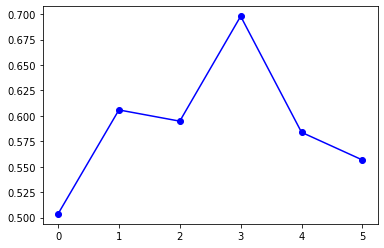

In [112]:
plt.plot(np.arange(len(AUC)), AUC, linestyle='-', marker='o', color='b')

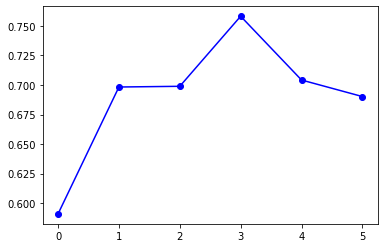

In [113]:
plt.plot(np.arange(len(AUC)), AP, linestyle='-', marker='o', color='b')

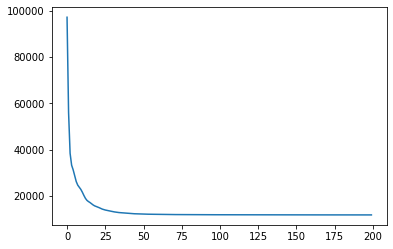

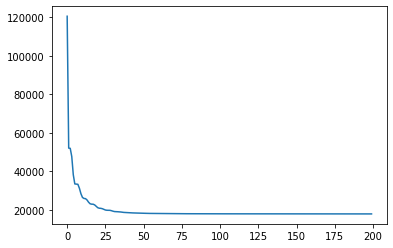

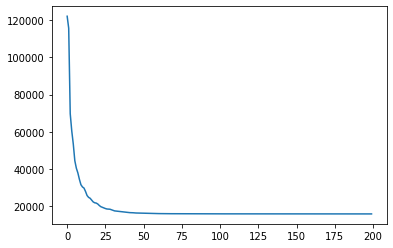

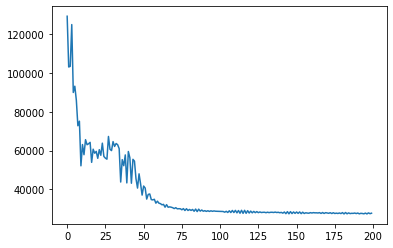

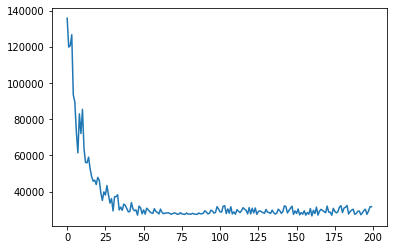

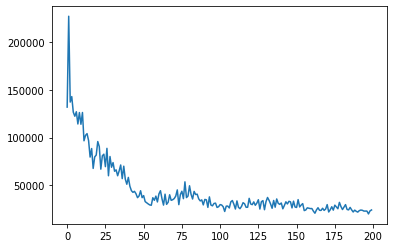

In [114]:
for l in Loss:
    plt.plot(l)
    plt.show()

In [117]:
len(dimensions)

6

In [119]:
OLD_AUC=[]
OLD_AP=[]
old_emb=[]
for i in range(len(PATCHES)):
    prob=l2g.AlignmentProblem(PATCHES[i])
    e=prob.get_aligned_embedding()
    old_emb.append(e)
    full_model_ip = tg.nn.VGAE(encoder=VGAEconv(dimensions[i], test_data.num_node_features))
    auc, ap= full_model_ip.test(torch.tensor(e), test_data.edge_index, neg_edges)
    OLD_AUC.append(auc)
    OLD_AP.append(ap)

Compute relative transformations:   0%|          | 0/92 [00:00<?, ?it/s]

Compute mean embedding:   0%|          | 0/11 [00:00<?, ?it/s]

Compute relative transformations:   0%|          | 0/92 [00:00<?, ?it/s]

Compute mean embedding:   0%|          | 0/11 [00:00<?, ?it/s]

Compute relative transformations:   0%|          | 0/92 [00:00<?, ?it/s]

Compute mean embedding:   0%|          | 0/11 [00:00<?, ?it/s]

Compute relative transformations:   0%|          | 0/92 [00:00<?, ?it/s]

Compute mean embedding:   0%|          | 0/11 [00:00<?, ?it/s]

Compute relative transformations:   0%|          | 0/92 [00:00<?, ?it/s]

Compute mean embedding:   0%|          | 0/11 [00:00<?, ?it/s]

Compute relative transformations:   0%|          | 0/92 [00:00<?, ?it/s]

Compute mean embedding:   0%|          | 0/11 [00:00<?, ?it/s]

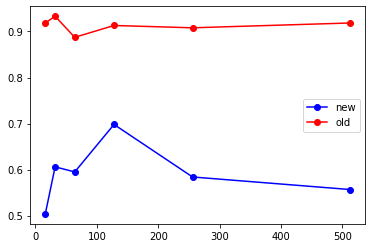

In [124]:
plt.plot(dimensions, AUC, linestyle='-', marker='o', color='b', label='new')
plt.plot(dimensions, OLD_AUC, linestyle='-', marker='o', color='r', label='old')
plt.legend()
plt.show()

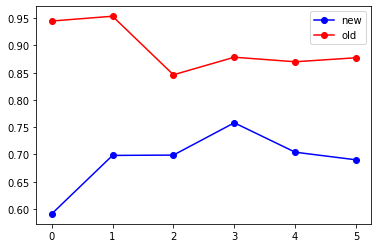

In [121]:
plt.plot(np.arange(len(AUC)), AP, linestyle='-', marker='o', color='b', label='new')
plt.plot(np.arange(len(AUC)), OLD_AP, linestyle='-', marker='o', color='r', label='old')
plt.legend()
plt.show()

In [122]:
from scipy.spatial import procrustes
ERR=[]
for i in range(len(dimensions)):
    _, _, error = procrustes(new_emb[i], old_emb[i])
    ERR.append(error)

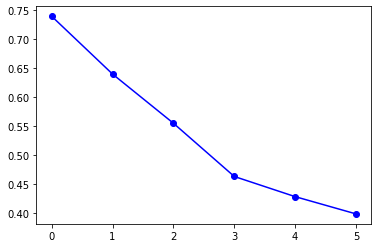

In [123]:
plt.plot(np.arange(len(AUC)), ERR, linestyle='-', marker='o', color='b')

###  <a id='chapter2'> <font color="grey">2. Embedding </font></a>

For the embedding, we use the architecture of a Variational Graph Autoencoder. Given a graph $G=(V,E)$ with $|V|=n$ nodes and node features ${x}_i\in \mathbb{R}^d$, $i\in [n]$, denote by ${X}=[{x}_1,\dots,{x}_n]^T\in \mathbb{R}^{n\times d}$ the features matrix and by $A=(a_{ij})\in \{0,1\}^{n\times n}$ the adjacency matrix of the graph. The **encoder** produces latent representations ${z}_i\in \mathbb{R}^k$ for $i\in [n]$, which are sampled from the inference model
\begin{equation*}
  q({z}_i \ | \ {X},{A}) = \mathcal{N}({z}_i \ | \ {\mu}_i,\mathrm{diag}({\sigma}_i)).
\end{equation*}
The means $\mu_i$ and variances $\mathrm{diag}({\sigma}_i)$ are parametrized using an encoder network, for example, a graph convolutional neural network (GCN). Denoting by ${Z}=[{z}_1,\dots,{z}_n]^T$ the matrix of latent represenations and by ${\mu}$ and ${\sigma}$ the matrices representing the means and variances, we have
\begin{equation*}
  {\mu} = \mathrm{GCN}_{\mu}({X},{A}), \quad \quad \log {\sigma} = \mathrm{GCN}_{\sigma}({X},{A}).
\end{equation*}
The **generative model** is a distribution on the adjacency matrix,
\begin{equation*}
  p({A}\ | \ {Z}) = \prod_{i,j} p(a_{ij} \ | \ {z}_i,{z}_j).
\end{equation*}
It is convenient to use
\begin{equation*}
  p(a_{ij}=1 \ | \ {z}_i,{z}_j) = \sigma({z}_i^T{z}_j),
\end{equation*}
where $\sigma$ is the logistic sigmoid. In order to train the model, we optimize the evidence lower bound
\begin{equation*}
  \mathcal{L} = \mathbb{E}_{q({Z}\ | \ {X},{A})}[\log p({A}\ | \ {Z})]-\mathrm{D}_{\mathrm{KL}}(q({Z}\ | \ {X},{A}) \ \| \ p({Z})).
\end{equation*}

In [24]:
model = GAE(dim=256, hidden_dim=128, num_features=data.num_node_features)

In [25]:
#def train(data, model, loss_fun, num_epochs=100, verbose=True, lr=0.01, logger=lambda loss: None):
  #  losses = []
 #   optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
  #  # schedule = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
  #  for e in tqdm(range(num_epochs)):
  #      optimizer.zero_grad()
    #    loss = loss_fun(model, data)
    #    loss.backward()
    #    optimizer.step()
    #    losses.append(float(loss))
    #    if verbose:
     #       if not e % 20:
     #           print(f'epoch {e}: loss={loss.item()}')
        # schedule.step()
    #return model, losses

In [26]:
#model, losses = train(data, model,GAE_loss, num_epochs=100)

In [27]:
plt.plot(losses)
plt.show()

NameError: name 'losses' is not defined

In [ ]:
embedding = model.encode(data).detach().numpy()
embedding.shape

In the original L2G code, there is a Patch class handling patches.

###  <a id='chapter3'> <font color="grey">3. Visualisation </font></a>

In [ ]:
most_common = ['AU', 'BR', 'CN']
countries = dl.get_nodes(ts=dates[0])['country'].to_list()
indices = [i for i in range(len(countries)) if countries[i] in most_common]

In [ ]:
points = embedding[indices, :]
labels = [most_common.index(countries[i]) for i in indices]

In [ ]:
# Use UMAP to visualise the graph embeddings for different days
reducer = umap.UMAP(n_neighbors=10, min_dist=0.00, metric='euclidean')

In [ ]:
#points = StandardScaler().fit_transform(points)
points

In [ ]:
umap_embedding = reducer.fit_transform(points)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(
    points[:, 0],
    points[:, 1],
    c=[sns.color_palette()[x] for x in labels],
    lw=1
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Embedding', fontsize=12)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c=[sns.color_palette()[x] for x in labels],
    lw=1
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Embedding', fontsize=12)
plt.show()

In [28]:
dim=2
n_patches=30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
patches= [ tg_graphs[d] for d in dates[:n_patches]]
    

In [33]:
patches_embedding, VGAE_model=VGAE_patch_embeddings(patches, dim=dim, hidden_dim=32, num_epochs=50, decoder=None, device=device, lr=0.01)

epoch 0: loss=1.8183332681655884
epoch 1: loss=1.7286288738250732
epoch 2: loss=1.6538267135620117
epoch 3: loss=1.6065369844436646
epoch 4: loss=1.5601023435592651
epoch 5: loss=1.5246920585632324
epoch 6: loss=1.4916727542877197
epoch 7: loss=1.4552620649337769
epoch 8: loss=1.4145761728286743
epoch 9: loss=1.3801597356796265
epoch 10: loss=1.3303579092025757
epoch 11: loss=1.2849384546279907
epoch 12: loss=1.2360200881958008
epoch 13: loss=1.1962257623672485
epoch 14: loss=1.167494773864746
epoch 15: loss=1.1542855501174927
epoch 16: loss=1.1506705284118652
epoch 17: loss=1.1479732990264893
epoch 18: loss=1.1423649787902832
epoch 19: loss=1.130204677581787
epoch 20: loss=1.1152303218841553
epoch 21: loss=1.0954545736312866
epoch 22: loss=1.0799859762191772
epoch 23: loss=1.064706563949585
epoch 24: loss=1.0500530004501343
epoch 25: loss=1.0417213439941406
epoch 26: loss=1.036286473274231
epoch 27: loss=1.0319632291793823
epoch 28: loss=1.028126835823059
epoch 29: loss=1.022954702377

epoch 44: loss=0.9352750778198242
epoch 45: loss=0.9355084300041199
epoch 46: loss=0.933463990688324
epoch 47: loss=0.9334523677825928
epoch 48: loss=0.9326539635658264
epoch 49: loss=0.9337729811668396
epoch 0: loss=1.7389259338378906
epoch 1: loss=1.6948637962341309
epoch 2: loss=1.6167941093444824
epoch 3: loss=1.573102593421936
epoch 4: loss=1.5186173915863037
epoch 5: loss=1.4710509777069092
epoch 6: loss=1.4128165245056152
epoch 7: loss=1.35611093044281
epoch 8: loss=1.2990716695785522
epoch 9: loss=1.2542462348937988
epoch 10: loss=1.2073475122451782
epoch 11: loss=1.1784305572509766
epoch 12: loss=1.1610456705093384
epoch 13: loss=1.1539485454559326
epoch 14: loss=1.1405702829360962
epoch 15: loss=1.1293916702270508
epoch 16: loss=1.1115447282791138
epoch 17: loss=1.0906119346618652
epoch 18: loss=1.0712653398513794
epoch 19: loss=1.0535056591033936
epoch 20: loss=1.0385147333145142
epoch 21: loss=1.0278640985488892
epoch 22: loss=1.0184701681137085
epoch 23: loss=1.01334869861

epoch 38: loss=0.9365001320838928
epoch 39: loss=0.9370334148406982
epoch 40: loss=0.9359393119812012
epoch 41: loss=0.9343234300613403
epoch 42: loss=0.9329422116279602
epoch 43: loss=0.9316033124923706
epoch 44: loss=0.9313104152679443
epoch 45: loss=0.9305852055549622
epoch 46: loss=0.9306595325469971
epoch 47: loss=0.9288727045059204
epoch 48: loss=0.9277167916297913
epoch 49: loss=0.9272453188896179
epoch 0: loss=1.7050737142562866
epoch 1: loss=1.6376488208770752
epoch 2: loss=1.5744062662124634
epoch 3: loss=1.5261212587356567
epoch 4: loss=1.4768846035003662
epoch 5: loss=1.4269887208938599
epoch 6: loss=1.3687924146652222
epoch 7: loss=1.3054782152175903
epoch 8: loss=1.2424440383911133
epoch 9: loss=1.1964812278747559
epoch 10: loss=1.1616384983062744
epoch 11: loss=1.1421606540679932
epoch 12: loss=1.1386628150939941
epoch 13: loss=1.1268794536590576
epoch 14: loss=1.117405652999878
epoch 15: loss=1.0948486328125
epoch 16: loss=1.0710431337356567
epoch 17: loss=1.04738831520

epoch 32: loss=0.9831262826919556
epoch 33: loss=0.9748022556304932
epoch 34: loss=0.9693297743797302
epoch 35: loss=0.9625515937805176
epoch 36: loss=0.9589661955833435
epoch 37: loss=0.9549975395202637
epoch 38: loss=0.9526513814926147
epoch 39: loss=0.94874107837677
epoch 40: loss=0.9467877149581909
epoch 41: loss=0.941573441028595
epoch 42: loss=0.9408177137374878
epoch 43: loss=0.9377127885818481
epoch 44: loss=0.9357125163078308
epoch 45: loss=0.9341672658920288
epoch 46: loss=0.9337446689605713
epoch 47: loss=0.9329743385314941
epoch 48: loss=0.9326521754264832
epoch 49: loss=0.9314610362052917
epoch 0: loss=1.6553219556808472
epoch 1: loss=1.588205337524414
epoch 2: loss=1.536555528640747
epoch 3: loss=1.489577293395996
epoch 4: loss=1.4244359731674194
epoch 5: loss=1.3610661029815674
epoch 6: loss=1.2859240770339966
epoch 7: loss=1.218628168106079
epoch 8: loss=1.1706304550170898
epoch 9: loss=1.1474460363388062
epoch 10: loss=1.1398428678512573
epoch 11: loss=1.13776826858520

epoch 27: loss=0.9672999382019043
epoch 28: loss=0.9616717100143433
epoch 29: loss=0.9569382667541504
epoch 30: loss=0.9553229808807373
epoch 31: loss=0.9510189294815063
epoch 32: loss=0.9486675262451172
epoch 33: loss=0.945694088935852
epoch 34: loss=0.9445459842681885
epoch 35: loss=0.9397624731063843
epoch 36: loss=0.9373486042022705
epoch 37: loss=0.9353430867195129
epoch 38: loss=0.9363089799880981
epoch 39: loss=0.9354344606399536
epoch 40: loss=0.9357889294624329
epoch 41: loss=0.9350521564483643
epoch 42: loss=0.9347767233848572
epoch 43: loss=0.9345320463180542
epoch 44: loss=0.9323269724845886
epoch 45: loss=0.9323750734329224
epoch 46: loss=0.9328485131263733
epoch 47: loss=0.9303383231163025
epoch 48: loss=0.9307072758674622
epoch 49: loss=0.9297037124633789
epoch 0: loss=1.8155747652053833
epoch 1: loss=1.7099344730377197
epoch 2: loss=1.6506571769714355
epoch 3: loss=1.5998460054397583
epoch 4: loss=1.5511198043823242
epoch 5: loss=1.5012555122375488
epoch 6: loss=1.44676

epoch 21: loss=1.0544513463974
epoch 22: loss=1.044603705406189
epoch 23: loss=1.0399036407470703
epoch 24: loss=1.0358997583389282
epoch 25: loss=1.0316420793533325
epoch 26: loss=1.0264285802841187
epoch 27: loss=1.018023133277893
epoch 28: loss=1.0108145475387573
epoch 29: loss=1.0032525062561035
epoch 30: loss=0.993445098400116
epoch 31: loss=0.9878811836242676
epoch 32: loss=0.982354998588562
epoch 33: loss=0.9765857458114624
epoch 34: loss=0.9728778004646301
epoch 35: loss=0.9699106216430664
epoch 36: loss=0.9671823382377625
epoch 37: loss=0.9644292593002319
epoch 38: loss=0.9588722586631775
epoch 39: loss=0.9555097222328186
epoch 40: loss=0.9529979228973389
epoch 41: loss=0.9509998559951782
epoch 42: loss=0.9504541754722595
epoch 43: loss=0.9477017521858215
epoch 44: loss=0.9480350017547607
epoch 45: loss=0.9454212784767151
epoch 46: loss=0.943938136100769
epoch 47: loss=0.9437795877456665
epoch 48: loss=0.9421513080596924
epoch 49: loss=0.9422210454940796
epoch 0: loss=1.705415

epoch 15: loss=1.115351915359497
epoch 16: loss=1.090338945388794
epoch 17: loss=1.0656782388687134
epoch 18: loss=1.0440372228622437
epoch 19: loss=1.02473783493042
epoch 20: loss=1.0109702348709106
epoch 21: loss=1.0026800632476807
epoch 22: loss=0.9942557215690613
epoch 23: loss=0.9874855279922485
epoch 24: loss=0.978994607925415
epoch 25: loss=0.9670261144638062
epoch 26: loss=0.9563136100769043
epoch 27: loss=0.9516518712043762
epoch 28: loss=0.9465218186378479
epoch 29: loss=0.9449506402015686
epoch 30: loss=0.9432404041290283
epoch 31: loss=0.9444301128387451
epoch 32: loss=0.9420732855796814
epoch 33: loss=0.9422962069511414
epoch 34: loss=0.9402437210083008
epoch 35: loss=0.9382897615432739
epoch 36: loss=0.9386165738105774
epoch 37: loss=0.9389564990997314
epoch 38: loss=0.937715470790863
epoch 39: loss=0.9367771148681641
epoch 40: loss=0.9353109002113342
epoch 41: loss=0.9336538314819336
epoch 42: loss=0.9314667582511902
epoch 43: loss=0.9294714331626892
epoch 44: loss=0.929

In [31]:
#patch_list = []
models = []
embeddings = []
patch_emb=[] #ADDED
for d in dates[:n_patches]:
    patch = tg_graphs[d]
    model = model = VGAE(dim=dim, hidden_dim=128, num_features=data.num_node_features)
    model, _ = train(patch, model, VGAE_loss, num_epochs=5, lr=0.01)
    patch_emb.append(Patch(patch.nodes, model.encode(patch).detach().numpy())) #ADDED
    #coordinates = model.encode(patch).detach().numpy()
    models.append(model)

  0%|          | 0/5 [00:00<?, ?it/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

In [ ]:
# Optimization on manifolds approach
intersection_nodes=mopt.double_intersections_nodes(patch_emb)
dim=64
res, emb = mopt.optimization(patch_emb, intersection_nodes, dim) #res contain the result of the optimization, i.e., scales, rotations and traslations,
                                                                # emb is the embedding of every nodes using the scales, rotations and translations 
                                                                #found with  the optimization

In [ ]:
# Standard l2g approach
pr = AlignmentProblem(patch_emb)
old_emb = pr.get_aligned_embedding()

In [ ]:
def reduce_data(data, date, most_common):
    countries = dl.get_nodes(ts=date)['country'].to_list()
    indices = [i for i in range(len(countries)) if countries[i] in most_common]
    points = data[indices, :]
    labels = [most_common.index(countries[i]) for i in indices]
    return points, labels

In [ ]:
def create_plot(umap_embedding, labels, p):
    fig, ax = plt.subplots(1, 1, figsize=(12,12))
    ax.scatter(
        umap_embedding[p][:, 0],
        umap_embedding[p][:, 1],
        c=[sns.color_palette()[x] for x in labels[p]],
        lw=1
    )
    return fig

In [ ]:
tg_graphs[dates[1]].nodes

In [ ]:
# Compute all embeddings (using GAE or VGAE)
dim = 64
#patch_list = []
models = []
embeddings = []
patch_emb = [] #ADDED
for d in dates[:5]:
    patch = tg_graphs[d]
    model = GAE(dim=64, hidden_dim=128, num_features=data.num_node_features)
    model, _ = train(patch, model, GAE_loss, num_epochs=40, lr=0.01)
    patch_emb.append(Patch(patch.nodes, model.encode(patch).detach().numpy())) #ADDED
    #coordinates = model.encode(patch).detach().numpy()
    models.append(model)

In [ ]:
reducer = umap.UMAP(n_neighbors=10, min_dist=0.01, metric='euclidean')

In [ ]:
for j, p in enumerate(patch_emb):
    p_countries = dl.get_nodes(ts=dates[j])['country'].to_list()
    p_indices = [i for i in range(len(p_countries)) if p_countries[i] in most_common]
    p_labels = [most_common.index(p_countries[i]) for i in p_indices]
    p_points = p.coordinates[p_indices, :]
    umap_embedding = reducer.fit_transform(p_points)

    fig, ax = plt.subplots(1, 1, figsize=(12,12))
    ax.scatter(
        umap_embedding[:, 0],
        umap_embedding[:, 1],
        c=[sns.color_palette()[x] for x in p_labels],
        lw=1
    )
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP Embedding', fontsize=12)
    plt.show()
    

## NEW VERSION OF ALIGNMENT

In [34]:
def double_intersections_nodes(patches):
    double_intersections = dict()
    for i in range(len(patches)):
        for j in range(i+1, len(patches)):
            double_intersections[(i,j)]=list(set(patches[i].nodes.tolist()).intersection(set(patches[j].nodes.tolist())))
    return double_intersections

def preprocess_graphs(list_of_patches, nodes_dict):
    emb_list = []
    for i in range(len(list_of_patches)-1):
        emb_list.append([torch.tensor(list_of_patches[i].get_coordinates(list(nodes_dict[i,i+1]))),
                         torch.tensor(list_of_patches[i+1].get_coordinates(list(nodes_dict[i,i+1])))])
    emb_list = list(itertools.chain.from_iterable(emb_list))
    return emb_list    


def get_embedding(patches, trained_model):
    scales = [ s.detach().numpy().item() for s in trained_model.s] 
    rots = [r.detach().numpy() for r in trained_model.R]
    shifts = [ s.detach().numpy() for s in trained_model.t] 

    emb_problem = AlignmentProblem(patches)
    embedding = np.empty((emb_problem.n_nodes, emb_problem.dim))
    for node, patch_list in enumerate(emb_problem.patch_index):
        embedding[node] = np.mean([emb_problem.patches[p].get_coordinate(node)@rots[i] + shifts[i] for i, p in enumerate(patch_list)], axis=0)
    return embedding


import torch
import torch.nn as nn
import geotorch


    
class Model(nn.Module):
    def __init__(self, dim, n_patches, device):
        super().__init__()
        self.device = device
        self.transformation = nn.ParameterList([nn.Linear(dim, dim).to(device) for _ in range(n_patches)])
        [geotorch.orthogonal(self.transformation[i], 'weight') for i in range(n_patches)]
    
    def forward(self, patch_emb):
        m = len(patch_emb)
        transformations = [self.transformation[0]] + [item for i in range(1, len(self.transformation)-1) for item in (self.transformation[i], self.transformation[i])] + [self.transformation[-1]]
        transformed_emb = [transformations[i](patch_emb[i]) for i in range(m)]
        return transformed_emb

def loss_function(transformed_emb):
    m = len(transformed_emb)
    diff = [transformed_emb[i] - transformed_emb[i+1] for i in range(0, m-1, 2)]
    loss = sum([torch.norm(d) ** 2 for d in diff])
    return loss

def train_model(patch_emb, dim, n_patches, num_epochs=100, learning_rate=0.05):
    #device = get_device()
    patch_emb = [p.to(device) for p in patch_emb]
    
    model = Model(dim, n_patches, device).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_hist = []
    
    for epoch in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        transformed_patch_emb = model(patch_emb)
        loss = loss_function(transformed_patch_emb)
        loss.backward(retain_graph=True)
        optimizer.step()
        loss_hist.append(loss.item())
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    
    return model, loss_hist


In [40]:
patch_emb=patches_embedding
patch_emb

In [41]:
#patch_emb

n_patches = len(patch_emb)
nodes = double_intersections_nodes(patch_emb)
emb_patches = preprocess_graphs(patch_emb, nodes)

#best_model, best_params, results = grid_search(emb_patches, dim, n_patches)



In [55]:
%timeit
res, loss_hist= train_model(emb_patches, dim, n_patches , num_epochs=100, learning_rate=0.5)
%time

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, Loss: 3922214.5
Epoch 10, Loss: 784976.25
Epoch 20, Loss: 421837.9375
Epoch 30, Loss: 297222.09375
Epoch 40, Loss: 236388.921875
Epoch 50, Loss: 220602.484375
Epoch 60, Loss: 214030.0
Epoch 70, Loss: 211398.796875
Epoch 80, Loss: 210384.828125
Epoch 90, Loss: 209840.921875
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


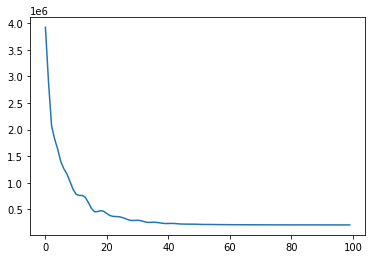

In [56]:
plt.plot(loss_hist)

In [44]:
def get_embedding(patches, result):
    n=len(patches)
    rot=[result.transformation[i].weight.to('cpu').detach().numpy() for i in range(n)]
    shift=[result.transformation[i].bias.to('cpu').detach().numpy() for i in range(n)]

    emb_problem = l2g.AlignmentProblem(patches)
    embedding = np.empty((emb_problem.n_nodes, emb_problem.dim))
    for node, patch_list in enumerate(emb_problem.patch_index):
        embedding[node] = np.mean([emb_problem.patches[p].get_coordinate(node)@rot[i] + shift[i] for i, p in enumerate(patch_list)], axis=0)

    #prob=l2g.AlignmentProblem(patches)
    #old_embedding=prob.get_aligned_embedding()
    #embedding=embedding[nodes]
    #old_embedding=old_embedding[nodes]
    #error= l2g.utils.procrustes_error(embedding,old_embedding)

    return embedding


In [45]:
emb=get_embedding(patch_emb, res)

In [51]:
%timeit
prob=l2g.AlignmentProblem(patches_embedding)
old_emb=prob.get_aligned_embedding()
%time

Compute relative transformations:   0%|          | 0/870 [00:00<?, ?it/s]

Compute mean embedding:   0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


In [57]:
print(f"Procrustes error: {l2g.utils.procrustes_error(old_emb, emb)}")

Procrustes error: 0.3325606459897007


In [46]:
full_model= tg.nn.VGAE(encoder=VGAEconv(dim, dim))
auc, ap = full_model_ip.test(torch.tensor(emb), test_data.edge_index, neg_edges)

NameError: name 'full_model_ip' is not defined

Best Params: {'learning_rate': 0.05, 'num_epochs': 500, 'weight_decay': 0, 'scaling_factor': 1} with Loss: 65.79495239257812
no scales

Best Params: {'learning_rate': 0.05, 'num_epochs': 500, 'weight_decay': 0, 'scaling_factor': 1} with Loss: 60.9526252746582  no scales


Best Params: {'learning_rate': 0.05, 'num_epochs': 500, 'weight_decay': 0.0001, 'scaling_factor': 1} with Loss: 81.65168762207031

In [ ]:
class AffineTransform(nn.Module):
    def __init__(self, patch_emb, dim, n_patches):
        super(AffineTransform, self).__init__()
        
        self.R = nn.ParameterList([nn.Parameter(torch.randn(dim, dim)) for _ in range(n_patches)])
        self.s=nn.ParameterList([nn.Parameter(torch.randn(1)) for _ in range(n_patches)]) #nn.ParameterList([1] + [nn.Parameter(torch.randn(1)) for _ in range(n_patches-1)])
        self.t = nn.ParameterList([nn.Parameter(torch.randn(dim)) for _ in range(n_patches)])
        
        # Parameters for Y transformation: W2 (d x d), b2 (d)
        #self.R2 = nn.Parameter(torch.randn(d, d))
        #self.s2=nn.Parameter(torch.randn(1))
        #self.t2 = nn.Parameter(torch.randn(d))

    def forward(self, patch_emb, n_patches, scales=True):
        
        m=2*n_patches -2
        R = [self.R[0]] + [item for i in range(1, n_patches-1) for item in (self.R[i], self.R[i])] +[self.R[-1]]
        
        t= [self.t[0]] + [item for i in range(1, n_patches-1) for item in (self.t[i], self.t[i])] + [self.t[-1]]

        s= [self.s[0]] + [item for i in range(1, n_patches-1) for item in (self.s[i], self.s[i])] +[self.s[-1]]
        
        transformed_emb= [s[i]*patch_emb[i] @ R[i] + t[i] for i in range(m)]
        
        
            
        
        
        
        return transformed_emb 


# Loss function
def loss_function(transformed_emb, rots):
    d = rots[0].shape[0]
    I = torch.eye(d)
    m=len(transformed_emb)
    
    diff=[transformed_emb[i] - transformed_emb[i+1] for i in range(0, m-1, 2)]
    
    l=sum([torch.norm(d)**2 for d in diff])

    ort_r=sum([torch.linalg.matrix_norm(R@R.T - I) for R in rots])
    loss=l+10000*ort_r
   
    
    return loss

def train_model(patch_emb, dim, n_patches , num_epochs=1000, learning_rate=0.01):
    loss_hist=[]
    
    
    model = AffineTransform(patch_emb, dim, n_patches)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        
     
        transformed_patch_emb = model(patch_emb, n_patches)
        
      
        loss = loss_function(transformed_patch_emb, model.R)
        
     
        
        loss.backward(retain_graph=True)
        optimizer.step()
        loss_hist.append(loss.item())
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    

    return model, loss_hist


In [ ]:
model2, loss_hist2=train_model(emb_patches, dim, n_patches , num_epochs=1000, learning_rate=0.5)

In [ ]:
plt.plot(loss_hist2)

In [ ]:
emb22=get_embedding(patch_emb, model2)

In [ ]:
print(f"Procrustes error: {l2g.utils.procrustes_error(old_emb, emb22)}")

In [ ]:
def double_intersections_nodes(patches):
    double_intersections = dict()
    for i in range(len(patches)):
        for j in range(i+1, len(patches)):
            double_intersections[(i,j)]=list(set(patches[i].nodes.tolist()).intersection(set(patches[j].nodes.tolist())))
    return double_intersections

def preprocess_graphs(list_of_patches, nodes_dict):
    emb_list = []
    for i in range(len(list_of_patches)-1):
        emb_list.append([torch.tensor(list_of_patches[i].get_coordinates(list(nodes_dict[i,i+1]))),
                         torch.tensor(list_of_patches[i+1].get_coordinates(list(nodes_dict[i,i+1])))])
    emb_list = list(itertools.chain.from_iterable(emb_list))
    return emb_list    


nodes=double_intersections_nodes(patch_emb)
emb_patch=preprocess_graphs(patch_emb, nodes)

In [ ]:
import torch
import torch.nn as nn
import geotorch

class Model(nn.Module):
    def __init__(self, patch_emb, dim, n_patches):
        super().__init__()
        
        self.transformation = nn.ParameterList([nn.Linear(dim, dim) for _ in range(n_patches)])
        [geotorch.orthogonal(self.transformation[i], 'weight') for i in range(n_patches)]

        # Works with tensors: Instantiate a CNN with kernels of rank 1
        #self.cnn = nn.Conv2d(16, 32, 3)
        #geotorch.low_rank(self.cnn, "weight", rank=1)

        # Weights are initialized to a random value when you put the constraints, but
        # you may re-initialize them to a different value by assigning to them
        #self.linear.weight = torch.eye(128, 64)
        # And that's all you need to do. The rest is regular PyTorch code

    def forward(self, patch_emb):
        # self.linear is orthogonal and every 3x3 kernel in self.cnn is of rank 1
        
        m=len(patch_emb)
        transformations= [self.transformation[0]] + [item for i in range(1, n_patches-1) for item in (self.transformation[i], self.transformation[i])] +[self.transformation[-1]]
        transformed_emb=[transformations[i](patch_emb[i]) for i in range(m)]
        return transformed_emb


def loss_function(transformed_emb):
    #d = rots[0].shape[0]
    #I = torch.eye(d)
    m=len(transformed_emb)
    
    diff=[transformed_emb[i] - transformed_emb[i+1] for i in range(0, m-1, 2)]
    
    loss=sum([torch.norm(d)**2 for d in diff])

    #ort_r=sum([torch.linalg.matrix_norm(R@R.T - I) for R in rots])
    #loss=l+10*ort_r
   
    
    return loss

def train_model(patch_emb, dim, n_patches , num_epochs=1000, learning_rate=0.01):
    loss_hist=[]
    
    
    model =Model(patch_emb, dim, n_patches)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        
     
        transformed_patch_emb = model(patch_emb)
        
      
        loss = loss_function(transformed_patch_emb)
        
     
        
        loss.backward(retain_graph=True)
        optimizer.step()
        loss_hist.append(loss.item())
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    

    return model, loss_hist

param_grid = {
    "learning_rate": [0.005, 0.05, 0.5], 
    "num_epochs": [500, 1000, 5000], 
    "weight_decay": [0, 1e-4, 1e-3], # regularization for Adam
   
}


from torch import optim
from tqdm import tqdm

def grid_search(patch_emb, dim, n_patches):
    best_model = None
    best_loss = float('inf')
    best_params = None
    results = []

    # Iterate over all hyperparameter combinations
    for lr, num_epochs, weight_decay in itertools.product(
        param_grid["learning_rate"], 
        param_grid["num_epochs"], 
        param_grid["weight_decay"], 
        #param_grid["scaling_factor"],
        #param_grid['scales']
    ):
        print(f"Training with lr={lr}, epochs={num_epochs}, wd={weight_decay}")  #scale={scaling_factor}

        
        def loss_function(transformed_emb):
    #d = rots[0].shape[0]
    #I = torch.eye(d)
            m=len(transformed_emb)
    
            diff=[transformed_emb[i] - transformed_emb[i+1] for i in range(0, m-1, 2)]
    
            loss=sum([torch.norm(d)**2 for d in diff])

    #ort_r=sum([torch.linalg.matrix_norm(R@R.T - I) for R in rots])
    #loss=l+10*ort_r
   
        
            return loss
        
        # Train model
        model = Model(patch_emb, dim, n_patches)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        loss_hist = []

        for epoch in tqdm(range(num_epochs)):
            optimizer.zero_grad()
            transformed_patch_emb = model(patch_emb)
            loss = loss_function(transformed_patch_emb)
            loss.backward(retain_graph=True)
            optimizer.step()
            loss_hist.append(loss.item())

        final_loss = loss_hist[-1]  # Use last recorded loss
        results.append((final_loss, lr, num_epochs, weight_decay))

        # Track best model
        if final_loss < best_loss:
            best_loss = final_loss
            best_model = model
            best_params = {"learning_rate": lr, "num_epochs": num_epochs, 
                           "weight_decay": weight_decay} #, "scaling_factor": scaling_factor}
    
    print(f"\nBest Params: {best_params} with Loss: {best_loss}")
    return best_model, best_params, results

last_best_model, last_best_params, last_results = grid_search(emb_patch, dim, n_patches)


In [ ]:
def get_error(patches, result):
    n=len(patches)
    rot=[result.transformation[i].weight.detach().numpy() for i in range(n)]
    shift=[result.transformation[i].bias.detach().numpy() for i in range(n)]

    emb_problem = l2g.AlignmentProblem(patches)
    embedding = np.empty((emb_problem.n_nodes, emb_problem.dim))
    for node, patch_list in enumerate(emb_problem.patch_index):
        embedding[node] = np.mean([emb_problem.patches[p].get_coordinate(node)@rot[i] + shift[i] for i, p in enumerate(patch_list)], axis=0)

    prob=l2g.AlignmentProblem(patches)
    old_embedding=prob.get_aligned_embedding()
    error= l2g.utils.procrustes_error(embedding,old_embedding)

    return embedding, old_embedding, error, rot

In [ ]:
last_best_emb, old_emb, error, rotations=get_error(patch_emb, last_best_model)

In [ ]:
error

In [ ]:
prob=l2g.AlignmentProblem(patch_emb)
old=prob.get_aligned_embedding()


In [ ]:

aligned_patches=preprocess_graphs(prob.patches, nodes)
m=len(aligned_patches)

l=[np.linalg.norm(aligned_patches[i]- aligned_patches[i+1])**2 for i in range(0, m-1, 2)]
l_not_aligned=[np.linalg.norm(emb_patch[i]- emb_patch[i+1])**2 for i in range(0, m-1, 2)]

In [ ]:
np.sum(l)

In [ ]:
np.sum(l_not_aligned)

In [ ]:
emb_problem = l2g.AlignmentProblem(patches)
embedding = np.empty((emb_problem.n_nodes, emb_problem.dim))
for node, patch_list in enumerate(emb_problem.patch_index):
    embedding[node] = np.mean([emb_problem.patches[p].get_coordinate(node)@RRR[i] + shift[i] for i, p in enumerate(patch_list)], axis=0)


In [ ]:
print(f"Procrustes error: {l2g.utils.procrustes_error(old_emb, embedding)}")

In [ ]:
np.shape(old_emb)

In [ ]:
R=prob.calc_synchronised_rotations()

In [ ]:
dist2=[]
for i in range(4):
    for j in range(4):
        dist2.append(np.linalg.norm(R[i]-R[j]))

In [ ]:
rot_er=[np.linalg.norm(rots[i]- R[i]) for i in range(4)]

In [ ]:
rot_er

In [ ]:
P=patch_emb[0].coordinates
P_rots=P@rots[0]
P_R= P@R[0]

In [ ]:
umap_P_rots=reducer.fit_transform(P_rots)
umap_P_R=reducer.fit_transform(P_R)

In [ ]:
plt.scatter(umap_P_rots[:,0], umap_P_rots[:,1], label='rots')
plt.scatter(umap_P_R[:,0], umap_P_R[:,1], label= 'R')
plt.legend()
plt.show()

In [ ]:
class AffineTransform(nn.Module):
    def __init__(self, patch_emb, dim, n_patches, scales=True):
        super(AffineTransform, self).__init__()
        self.R = nn.ParameterList([nn.Parameter(torch.randn(dim, dim)) for _ in range(n_patches)])
        
        self.t = nn.ParameterList([nn.Parameter(torch.randn(dim)) for _ in range(n_patches)])

        if scales:
            self.s=nn.ParameterList([nn.Parameter(torch.randn(1)) for _ in range(n_patches)]) #nn.ParameterList([1] + [nn.Parameter(torch.randn(1)) for _ in range(n_patches-1)])
    
        # Parameters for Y transformation: W2 (d x d), b2 (d)
        #self.R2 = nn.Parameter(torch.randn(d, d))
        #self.s2=nn.Parameter(torch.randn(1))
        #self.t2 = nn.Parameter(torch.randn(d))

    def forward(self, patch_emb, n_patches, scales=True):
        
        m=2*n_patches -2
        R = [self.R[0]] + [item for i in range(1, n_patches) for item in (self.R[i], self.R[i])]
        
        t= [self.t[0]] + [item for i in range(1, n_patches) for item in (self.t[i], self.t[i])]

        if scales:
            s= [self.s[0]] + [item for i in range(1, n_patches) for item in (self.s[i], self.s[i])]
            
            transformed_emb= [s[i]*patch_emb[i] @ R[i] + t[i] for i in range(m)]
        else:
             transformed_emb= [patch_emb[i] @ R[i] + t[i] for i in range(m)]
        return transformed_emb



# Loss function
def loss_function(transformed_emb, rots):
    d = rots[0].shape[0]
    I = torch.eye(d)
    m=len(transformed_emb)
    
    diff=[transformed_emb[i] - transformed_emb[i+1] for i in range(0, m-1, 2)]
    
    l=sum([torch.norm(d)**2 for d in diff])

    ort_r=sum([torch.linalg.matrix_norm(R@R.T - I) for R in rots])
    loss=l+100*ort_r
   
    
    return loss

def train_model(patch_emb, dim, n_patches , num_epochs=1000, learning_rate=0.01):
    loss_hist=[]
    
    
    model = AffineTransform(patch_emb, dim, n_patches)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        
     
        transformed_patch_emb = model(patch_emb, n_patches)
        
      
        loss = loss_function(transformed_patch_emb, model.R)
        
     
        
        loss.backward(retain_graph=True)
        optimizer.step()
        loss_hist.append(loss.item())
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    

    return model, loss_hist

def get_embedding(patches, trained_model):
    scales=[ s.detach().numpy().item() for s in trained_model.s]   #[1]+ [ s.detach().numpy().item() for s in trained_model.s[1:]] 
    rots=[r.detach().numpy() for r in trained_model.R]
    shifts=[ s.detach().numpy() for s in trained_model.t] 

    emb_problem = l2g.AlignmentProblem(patches)
    embedding = np.empty((emb_problem.n_nodes, emb_problem.dim))
    for node, patch_list in enumerate(emb_problem.patch_index):
        embedding[node] = np.mean([scales[i]*emb_problem.patches[p].get_coordinate(node)@rots[i] + shifts[i] for i, p in enumerate(patch_list)], axis=0)
    return embedding

In [ ]:
model2, loss_hist2=train_model(emb_patches, dim, n_patches , num_epochs=5000, learning_rate=0.05)

In [ ]:
emb2=get_embedding(patch_emb, model2)

In [ ]:
print(f"Procrustes error: {l2g.utils.procrustes_error(old_emb, emb2)}")

In [ ]:
def loss_at_node_patch_p(p,node, rots,shifts, scales, patches):
    i=patches.index(p)
    q=patches[i+1]    
    #rots=[torch.tensor(r) for r in rots]
    #shifts=[torch.tensor(s) for s in shifts]
    #scales=[torch.tensor(s) for s in scales]
    
    return torch.norm( scales[i]*p.get_coordinate(node)@rots[i] + shifts[i] -(scales[i+1]*q.get_coordinate(node)@rots[i+1] +shifts[i+1]))**2
        
def grad_loss_at_node_patch_p(p, node, rots,shifts, scales, patches):
    i=patches.index(p)
    W=rots[i].clone().detach().requires_grad_(True)
    rots[i]=W
    g=loss_at_node_patch_p(p, node, rots,shifts, scales, patches).clone().detach().requires_grad_(True)
    W.retain_grad()
    g.backward()
    return W.grad
        

def min_loss(Rotations, scales, translations , patches, nodes):
    l=0
    fij=dict()
    for i, p in enumerate(patches[:len(patches)-1]):
        q=patches[i+1]
        for n in nodes[i,i+1]:
            theta1=scales[i]*p.get_coordinate(n)@Rotations[i]+ translations[i]
            theta2= scales[i+1]*q.get_coordinate(n)@Rotations[i+1]+translations[i+1]
            l+=np.linalg.norm(theta1-theta2)**2
            #fij[(i, j+1+i, n)]=[theta1, theta2]
    return l#, fij

def numbering_tangent_coordinates(dim):
    return {i: (j, l) for i, (j, l) in enumerate((j, l) for j in range(dim) for l in range(j + 1, dim))}

def get_coordinates_from_index(i, dim):
    return numbering_tangent_coordinates(dim)[i]


def select_coordinate(X):
    return torch.argmax(torch.norm(X, dim=0)).item()

def basis(j, l, dim):
    ej=torch.zeros((dim,1))
    ej[j]=1
    el=torch.zeros((dim,1))
    el[l]=1
    return 1/np.sqrt(2)* (ej@el.t() - el@ej.t()).numpy() #.type(torch.float64)
    


#def grad_s_X_R_norm(scale, emb, rot):
    #rot=torch.tensor(rot, requires_grad=True)
    #pr=torch.norm(scale*emb@rot)**2
    #pr.backward()
    #return rot.grad
def grad_s_X_R_norm(scale, emb, rot):
    return 2*scale**2*emb*rot


def grad_s_X_R_scalar_y(scale, emb ,rot, y):
    #rot=torch.tensor(rot, requires_grad=True)
    
    #pr=torch.dot((scale*emb@rot).to(torch.float32), shift.to(torch.float32))
    #pr.backward()
    return 2*scale*emb@rot@y

def EU_grad_R(p, dict_nodes, rots, shifts, scales, patches):
    
    i=patches.index(p)
    W=rots[i]
    s=scales[i]
    dim=np.shape(W)[0]
    #W=torch.tensor(rots[i])
    if i==len(patches)-1:
        p_=patches[i-1]
        s_=scales[i-1]
        t_=shifts[i-1]
        R_=rots[i-1]
        grad=np.zeros((dim, dim)) #0
        for node in dict_nodes[i-1, i]:
            X=p.get_coordinate(node)
            Y=p_.get_coordinate(node)
            theta=s_*Y@R_ + t_
            grad+=grad_s_X_R_norm(s, X, W) + grad_s_X_R_scalar_y(s, X, W, shifts[i]) - grad_s_X_R_scalar_y(s, X, W, theta)
        return grad
    else:
        p_=patches[i+1]
        s_=scales[i+1]
        t_=shifts[i+1]
        R_=rots[i+1]
        grad=np.zeros((dim, dim)) #0
        for node in dict_nodes[i, i+1]:
            X=p.get_coordinate(node)
            Y=p_.get_coordinate(node)
            theta=s_*Y@R_ + t_
            grad+=grad_s_X_R_norm(s, X, W) + grad_s_X_R_scalar_y(s, X, W, shifts[i]) - grad_s_X_R_scalar_y(s, X, W, theta)
        if i==0:
            return grad
        else:
            p_=patches[i-1]
            s_=scales[i-1]
            t_=shifts[i-1]
            R_=rots[i-1]
            for node in dict_nodes[i-1, i]:
                X=p.get_coordinate(node)
                Y=p_.get_coordinate(node)
                theta=s_*Y@R_ + t_
                grad+=grad_s_X_R_norm(s, X, W) + grad_s_X_R_scalar_y(s, X, W, shifts[i]) - grad_s_X_R_scalar_y(s, X, W, theta)
            return grad
        
        
def grad_s(p, dict_nodes, rots, shifts, scales, patches):
    i=patches.index(p)
    s=scales[i]
    #W=torch.tensor(rots[i])
    if i==len(patches)-1:
        p_=patches[i-1]
        s_=scales[i-1]
        t_=shifts[i-1]
        R_=rots[i-1]
        grad=0
        for node in dict_nodes[i-1, i]:
            X=p.get_coordinate(node)
            Y=p_.get_coordinate(node)
            theta=s_*Y@R_ + t_
            X_R=X@rots[i]
            grad+=2*s*np.linalg.norm(X_R) + 2*X_R@shifts[i] - 2*X_R@theta
        return grad
    else:
        p_=patches[i+1]
        s_=scales[i+1]
        t_=shifts[i+1]
        R_=rots[i+1]
        grad=0
        for node in dict_nodes[i, i+1]:
            X=p.get_coordinate(node)
            Y=p_.get_coordinate(node)
            theta=s_*Y@R_ + t_
            X_R=X@rots[i]
            grad+=2*s*np.linalg.norm(X_R) + 2*X_R@shifts[i] - 2*X_R@theta
        if i==0:
            return grad
        else:
            p_=patches[i-1]
            s_=scales[i-1]
            t_=shifts[i-1]
            R_=rots[i-1]
            for node in dict_nodes[i-1, i]:
                X=p.get_coordinate(node)
                Y=p_.get_coordinate(node)
                theta=s_*Y@R_ + t_
                X_R=X@rots[i]
                grad+=2*s*np.linalg.norm(X_R) + 2*X_R@shifts[i] - 2*X_R@theta
            return grad
            
def grad_t(p, dict_nodes, rots, shifts, scales, patches):
    i=patches.index(p)
    s=scales[i]
    #W=torch.tensor(rots[i])
    if i==len(patches)-1:
        p_=patches[i-1]
        s_=scales[i-1]
        t_=shifts[i-1]
        R_=rots[i-1]
        grad=np.zeros(np.shape(shifts[0]))
        for node in dict_nodes[i-1, i]:
            X=p.get_coordinate(node)
            Y=p_.get_coordinate(node)
            theta=s_*Y@R_ + t_
            s_X_R=s*X@rots[i]
            grad+=2*(s_X_R + shifts[i] - theta)
        return grad
    else:
        p_=patches[i+1]
        s_=scales[i+1]
        t_=shifts[i+1]
        R_=rots[i+1]
        grad=np.zeros(np.shape(shifts[0]))
        for node in dict_nodes[i, i+1]:
            X=p.get_coordinate(node)
            Y=p_.get_coordinate(node)
            theta=s_*Y@R_ + t_
            s_X_R=s*X@rots[i]
            grad+=2*(s_X_R + shifts[i] - theta)
        if i==0:
            return grad
        else:
            p_=patches[i-1]
            s_=scales[i-1]
            t_=shifts[i-1]
            R_=rots[i-1]
            for node in dict_nodes[i-1, i]:
                X=p.get_coordinate(node)
                Y=p_.get_coordinate(node)
                theta=s_*Y@R_ + t_
                s_X_R=s*X@rots[i]
                grad+=2*(s_X_R + shifts[i] - theta)
            return grad


def euclidean_grad_loss(W, p ,node, rots, shifts, scales, patches):
    i=patches.index(p)
    if i==len(patches):
        q=patches[i-1]
        theta=scales[i-1]*q.get_coordinate(node)@rots[i-1]
    else:
        q=patches[i+1]
        theta=scales[i+1]*q.get_coordinate(node)@rots[i+1]
    s=scales[i]
    W=torch.tensor(rots[i])#, requires_grad=True)
    X=torch.tensor(p.get_coordinate(node))
    Y=torch.tensor(q.get_coordinate(node))
        
    if i==0 or i==len(patches):
        return grad_s_X_R_norm(s, X, W) + grad_s_X_R_scalar_y(s, X, W, torch.tensor(shifts[i])) - grad_s_X_R_scalar_y(s, X, W, torch.tensor(theta))
    else:
        if node in set(patches[i-1].nodes):
            theta2=scales[i-1]*patches[i-1].get_coordinate(node)@rots[i-1]
            return 2*(grad_s_X_R_norm(s, X, W) + grad_s_X_R_scalar_y(s, X, W, torch.tensor(shifts[i])))- grad_s_X_R_scalar_y(s, X, W, torch.tensor(theta +theta2))
        else:
            return grad_s_X_R_norm(s, X, W) + grad_s_X_R_scalar_y(s, X, W, torch.tensor(shifts[i])) - grad_s_X_R_scalar_y(s, X, W, torch.tensor(theta))

    
def riemannian_gradient(eucl_grad_h, W):
    #dim=np.shape(W)[0]
   # D=int(0.5*dim*(dim-1))
    #r_grad=[]
    #for index in range(D):
        #j=get_coordinates_from_index(index, dim)[0]
        #l=get_coordinates_from_index(index, dim)[1]
        #Hjl=basis(j, l, dim)
        #r_grad.append(np.trace(Hjl.t()@np.transpose(W)@eucl_grad_h))
    #W=torch.tensor(W)
    return 0.5*(eucl_grad_h- W@np.transpose(eucl_grad_h)@W  )                  #torch.tensor(r_grad)


def givens_matrix(j, l, alpha, dim):

    
    row_col = torch.tensor([list(range(dim))+ [j, l], 
                 list(range(dim))+  [l, j ]])

    values=torch.tensor([1] * j +
                 [np.cos(alpha)] + 
                 [1] * (l-j-1) + 
                 [np.cos(alpha)] + 
                 [1]*(dim-l-1) +
                 [np.sin(alpha) , -np.sin(alpha)],
                dtype=torch.float64)
    row=row_col[0,:].numpy()
    col=row_col[1,:].numpy()

    S=torch.sparse_coo_tensor(row_col, values, [dim, dim])
    T= coo_matrix((values, (row, col)), shape=(dim, dim))


    return  T
#def grad_s():
    
    
    
def update(W, grad, alpha, index):
    dim=np.shape(W)[0]
    jl=get_coordinates_from_index(index, dim)
    j=jl[0]
    l=jl[1]
    Hjl=basis(j,l,dim)
    W=torch.tensor(W)
    eta=W@Hjl
    grad_eta=torch.trace(grad.t()@eta)
    grad_direction_index=grad_eta*eta
    givens_m=givens_matrix(j, l, -alpha*grad_eta, dim)
    W_new=torch.sparse.mm(W, givens_m)
    return W_new
   




def one_step_rie_grad_descent( p,patches, dict_nodes, rots, shifts, scales, alpha, tang_basis):
    W=rots[patches.index(p)]
    s=scales[patches.index(p)]
    t=shifts[patches.index(p)]
    dim=np.shape(W)[0]
    D=int(0.5*dim*(dim-1))
    e_grad=EU_grad_R(p, dict_nodes, rots, shifts, scales, patches)
    t_grad=grad_t(p, dict_nodes, rots, shifts, scales, patches)
    s_grad=grad_s(p, dict_nodes, rots, shifts, scales, patches)
    s_new=s-alpha*s_grad
    t_new=t-alpha*t_grad
    #for n in nodes:
        #e_grad.append(euclidean_grad_loss(W, p ,n, rots, shifts, scales, patches))

    #e_grad=sum(e_grad)
    #W=torch.tensor(W)

    tang_basis=[W@e for e in tang_basis]
    
    R_grad=0.5*(e_grad- W@np.transpose(e_grad)@W  ) #riemannian_gradient(e_grad, W)
    g_W_i=np.stack([ np.trace(np.transpose(R_grad)@ e)*e for e in tang_basis])


    index=np.argmax([np.trace(np.transpose(g_W_i[i,:,:])@g_W_i[i,:,:]) for i in range(D)])
    grad_eta_direction_index=g_W_i[index]
    phi=np.trace(np.transpose(R_grad)@ tang_basis[index])
    jl=get_coordinates_from_index(index, dim)
    j=jl[0]
    l=jl[1]
    givens_m=givens_matrix(j, l, -alpha*phi, dim)
    W_new=W@givens_m #torch.sparse.mm(W, givens_m) 
    return W_new, t_new, s_new
        
        
        
def optimize_rotations(list_of_patches, dict_nodes, list_rots, list_shifts, list_scales, learning_rate, tangent_space_basis):
    #rots=[ortho_group.rvs(dim=5) for i in range(n_patches)]
    n_patches=len(list_of_patches)
    for i, p in enumerate(list_of_patches[:n_patches]):
        W_new, t_new, s_new=one_step_rie_grad_descent(p, list_of_patches, dict_nodes, list_rots, list_shifts, list_scales, learning_rate, tangent_space_basis)
        list_rots[i]=W_new #.numpy()
        list_shifts[i]=t_new
        list_scales[i]=s_new
    return list_rots, list_shifts, list_scales
        
def optimize_rotations_two_patches(list_of_patches, dict_nodes, list_rots, list_shifts, list_scales, learning_rate, tangent_space_basis):
    #rots=[ortho_group.rvs(dim=5) for i in range(n_patches)]
    nodes=list(dict_nodes.values())[0]
    P=list_of_patches[0]
    Q=list_of_patches[1]
    if len(nodes)>0:
        W1_new=one_step_rie_grad_descent(P, list_of_patches, nodes, list_rots, list_shifts, list_scales, learning_rate, tangent_space_basis)
        list_rots[0]=W1_new.numpy()
        W2_new=one_step_rie_grad_descent(Q, list_of_patches[::-1], nodes[::-1], list_rots[::-1], list_shifts[::-1], list_scales[::-1], learning_rate, tangent_space_basis)
        list_rots[1]=W2_new.numpy()
    return list_rots    

In [ ]:
dim=254
patches=patch_emb
n_patches=len(patches)
rots=[ortho_group.rvs(dim) for i in range(n_patches)]
scales=np.random.randn(len(patches)) #ones(len(patches))
shifts=np.random.rand(len(patches), dim)
alpha=0.00005
D=int(0.5*dim*(dim-1))

coordinates=numbering_tangent_coordinates(dim)
list_coordinates=list(coordinates.values())
tang_basis=[basis(j[0],j[1],dim) for j in tqdm(list_coordinates)]


In [ ]:
intersections=nodes
l=min_loss(rots, scales, shifts , patches, intersections)
l

In [ ]:
loss_hist=[]
for k in tqdm(range(50)):
    rots, shifts, scales= optimize_rotations(patches, intersections, rots, shifts, scales, alpha, tang_basis)
    loss=min_loss(rots, scales, shifts , patches, nodes)
    loss_hist.append(loss)
    #if k%5==0:
    print(f"loss: {loss}")